In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = 'c:/Users/admin/Documents/Datasets/chinese_calligraphy/train/'

train_images = tf.keras.utils.image_dataset_from_directory(path, image_size=(64, 64), batch_size=512)

Found 1330 files belonging to 5 classes.


In [3]:
train_images

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
for x, y in train_images.take(1):
    print(x.shape)

(512, 64, 64, 3)


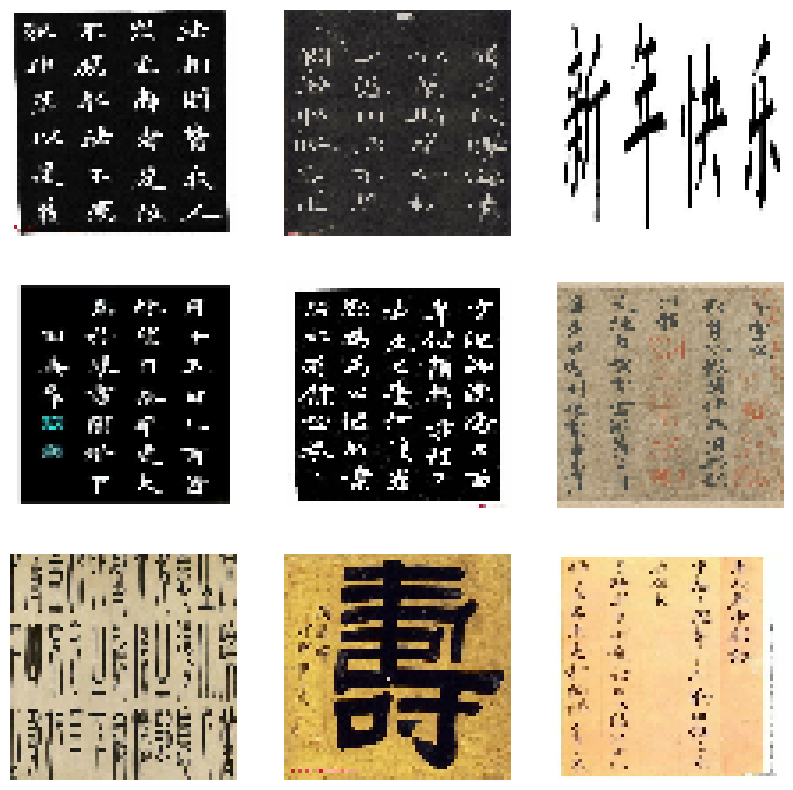

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [6]:
normalization_layer = layers.Rescaling(1./255)
normalized_train_images = train_images.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_images))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.95070565


In [15]:
image_shape = (64, 64, 3)
batch_size = 512

In [24]:
class WGAN_GP():
    def __init__(self, input_shape):

        self.z_dim = 128
        self.input_shape = input_shape

        self.loss_critic = {}
        self.loss_gp = {}
        self.loss_generator = {}
        
        # critic
        self.n_critic = 5
        self.penalty_const = 10
        self.critic = self.build_critic()
        self.critic.trainable = False

        self.optimizer_critic = Adam(1e-4, 0.5, 0.9)

        # build generator pipeline with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss = self.wasserstein_loss,
                           optimizer = Adam(1e-4, 0.5, 0.9))
        self.critic.trainable = True
        
    def wasserstein_loss(self, y_true, y_pred):

        w_loss = -tf.reduce_mean(y_true*y_pred)

        return w_loss

    def build_generator(self):

        DIM = 128
        model = tf.keras.Sequential(name='Generator') 

        model.add(layers.Input(shape=[self.z_dim])) 

        model.add(layers.Dense(4*4*8*DIM))
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())
        model.add(layers.Reshape((4,4,8*DIM))) 

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(4*DIM, 5, padding='same')) 
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(2*DIM, 5, padding='same')) 
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(DIM, 5, padding='same')) 
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))       
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')) 

        return model             
    
    def build_critic(self):

        DIM = 128
        model = tf.keras.Sequential(name='critics') 

        model.add(layers.Input(shape=self.input_shape)) 

        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(8*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Flatten()) 
        model.add(layers.Dense(1)) 

        return model     
    
 
    def gradient_loss(self, grad):

        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        loss = self.penalty_const * loss
        return loss

    def train_critic(self, real_images, batch_size):
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
                  
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input, verbose=0)
        
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)
            
            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)           
            
            # gradient penalty      
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            
            critic_interpolates = self.critic(interpolates)
            gradients_interpolates = gradient_tape.gradient(critic_interpolates, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_interpolates)
     
            # total loss
            total_loss = loss_fake + loss_real + gradient_penalty
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.trainable_variables)
            
            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.trainable_variables))

        return loss_fake, loss_real, gradient_penalty
                                                
    def train(self, data_generator, batch_size, steps, interval=100):

        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)

        for i in range(steps):
            for _ in range(self.n_critic):
                real_images = data_generator
                loss_fake, loss_real, gradient_penalty = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            self.loss_gp[i] = gradient_penalty
            self.loss_critic[i] = critic_loss.numpy()
            self.loss_generator[i] = g_loss
            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} critic_loss {:.4f} critic fake {:.4f}  critic_real {:.4f} penalty {:.4f}"\
                .format(i, g_loss, critic_loss, loss_fake, loss_real, gradient_penalty)
                print(msg)

                fake_images = self.generator.predict(val_g_input, verbose=0)
                self.plot_images(fake_images)
                self.plot_losses()

    def plot_images(self, images):   
        grid_row = 1
        grid_col = 6
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*3.5, grid_row*3.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1]==1:
                    axarr[col].imshow(images[col,:,:,0]*0.5+0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5+0.5)
                axarr[col].axis('off') 
        plt.show()

    def plot_losses(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critic loss', alpha=0.7)
        ax1.set_title("Critic loss")
        ax2.plot(list(self.loss_generator.values()), label='Generator loss', alpha=0.7)
        ax2.set_title("Generator loss")
        ax3.plot(list(self.loss_gp.values()), label='Gradient penalty', alpha=0.7)
        ax3.set_title("Gradient penalty")
        plt.xlabel('Steps')
        plt.show()

In [27]:
wgan = WGAN_GP(image_shape)

Step 0: g_loss 3.2272 critic_loss -5.0848 critic fake -2.3726  critic_real -2.7122 penalty 0.5300


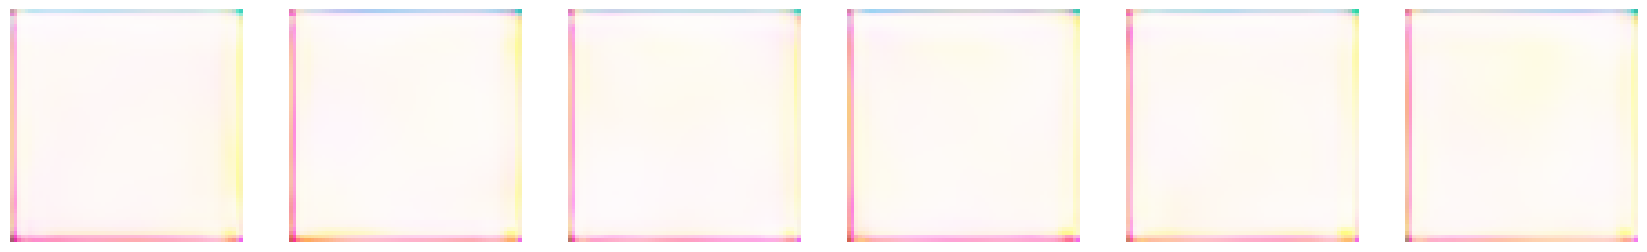

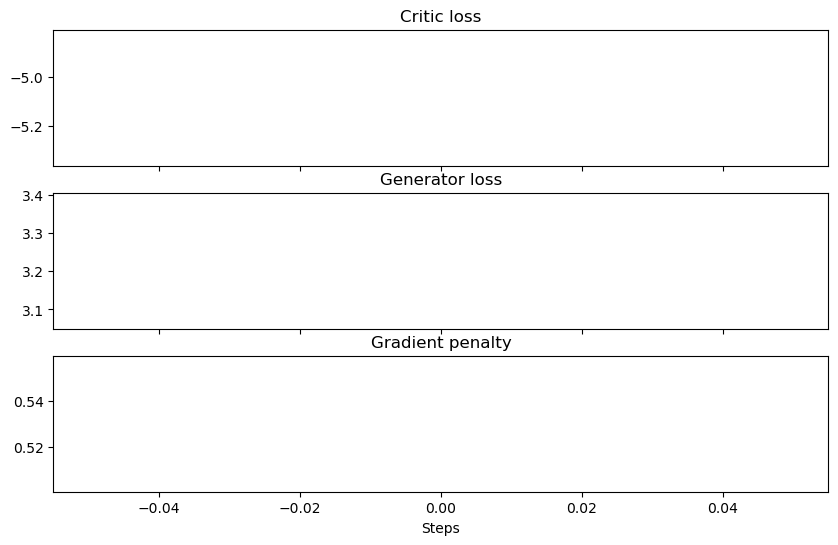

Step 30: g_loss 1.5340 critic_loss -1.3276 critic fake -3.0081  critic_real 1.6804 penalty 0.3273


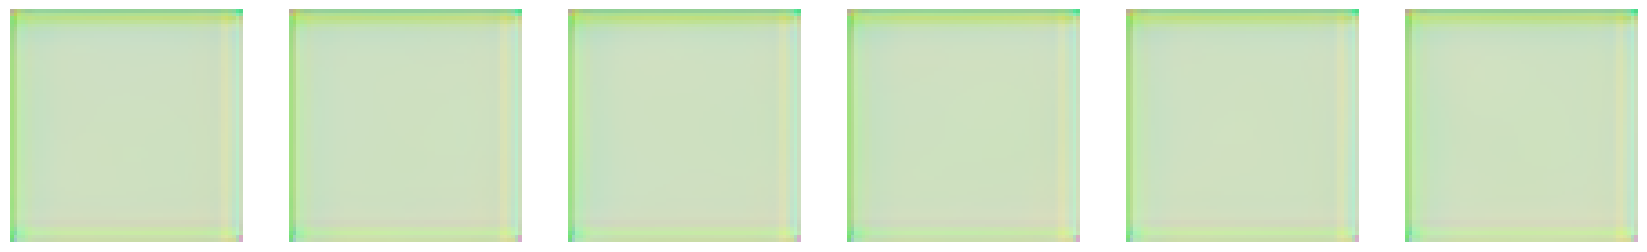

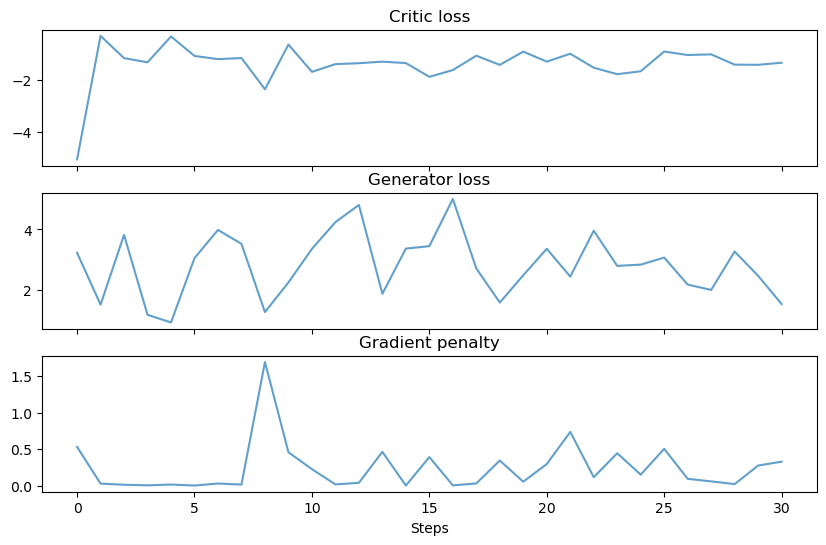

Step 60: g_loss 0.1297 critic_loss -1.6105 critic fake -0.2435  critic_real -1.3670 penalty 0.3140


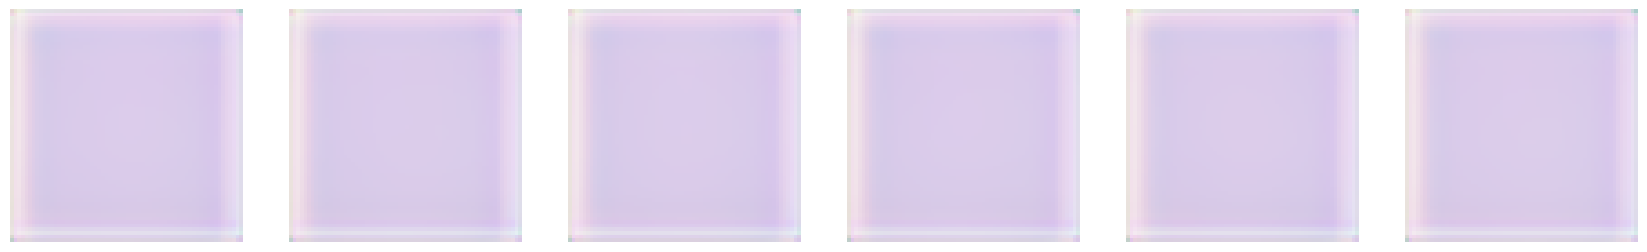

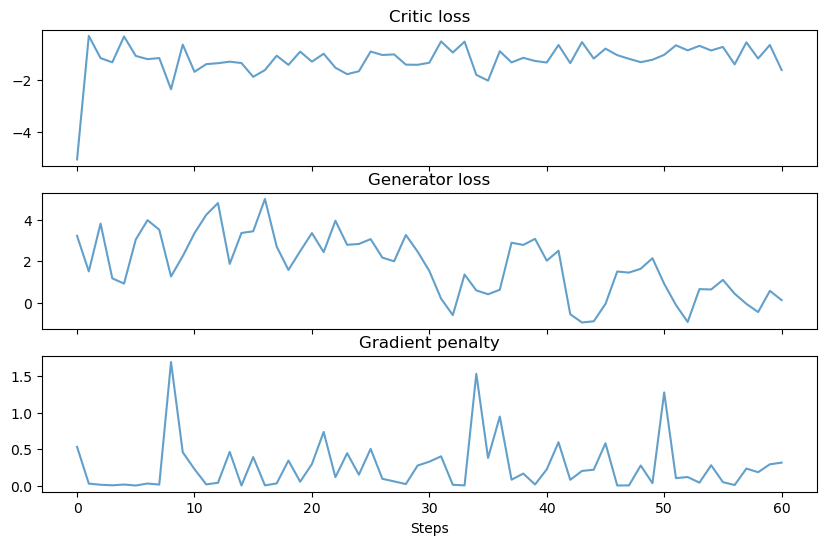

Step 90: g_loss 0.0953 critic_loss -1.1715 critic fake -0.2506  critic_real -0.9209 penalty 0.1298


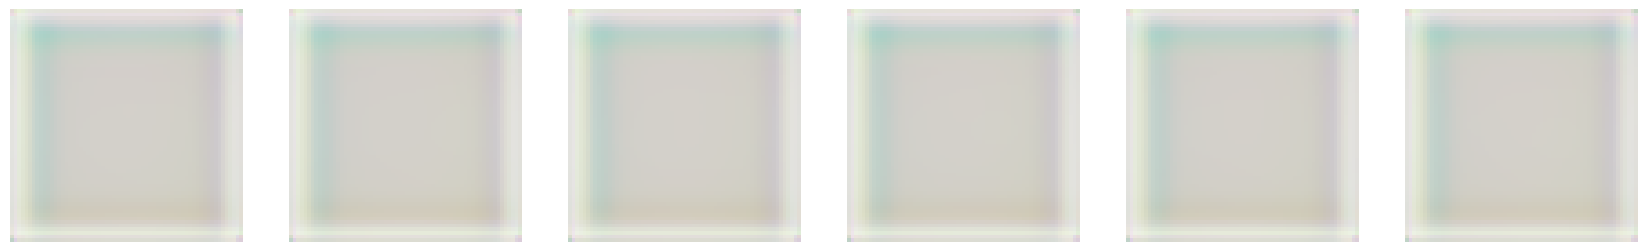

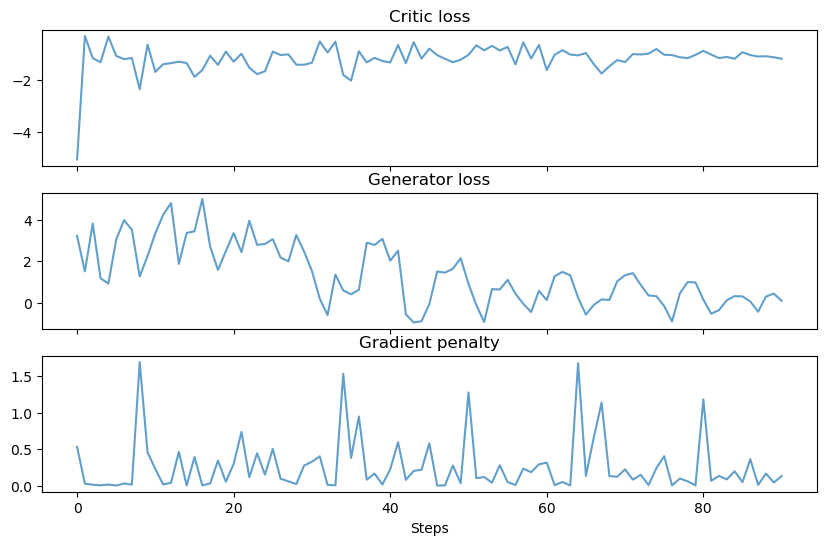

Step 120: g_loss -0.3525 critic_loss -0.9931 critic fake 0.3050  critic_real -1.2981 penalty 0.0449


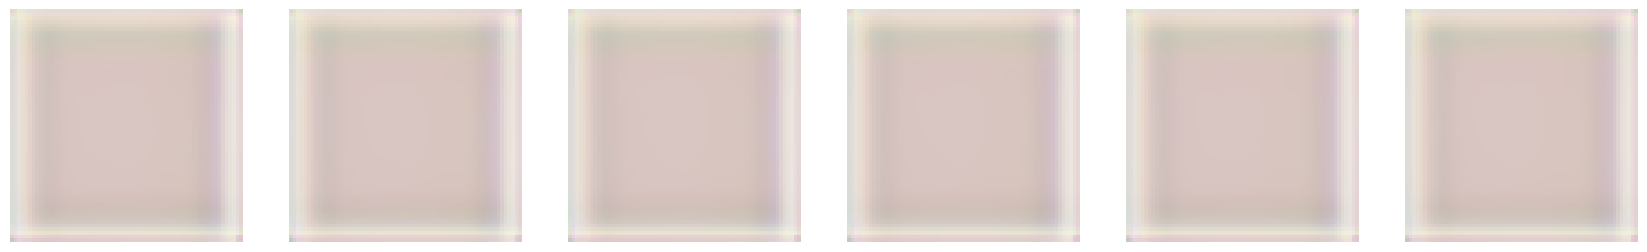

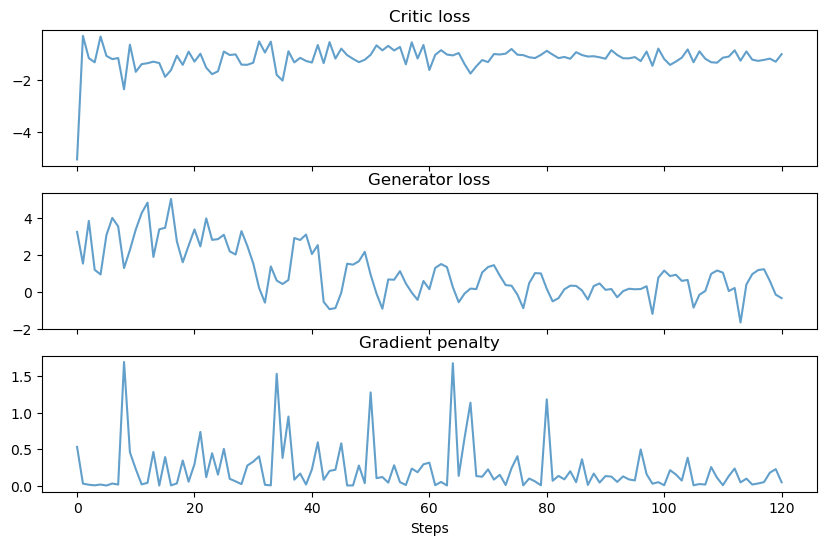

Step 150: g_loss 0.0930 critic_loss -1.0307 critic fake 0.1752  critic_real -1.2059 penalty 0.0298


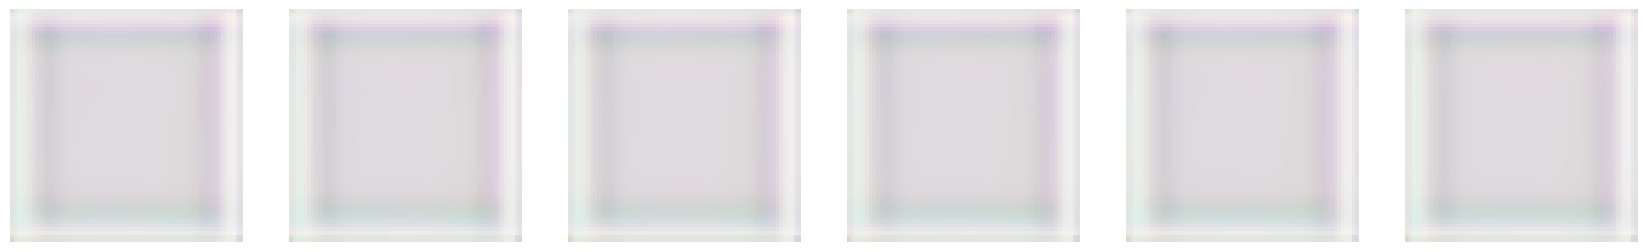

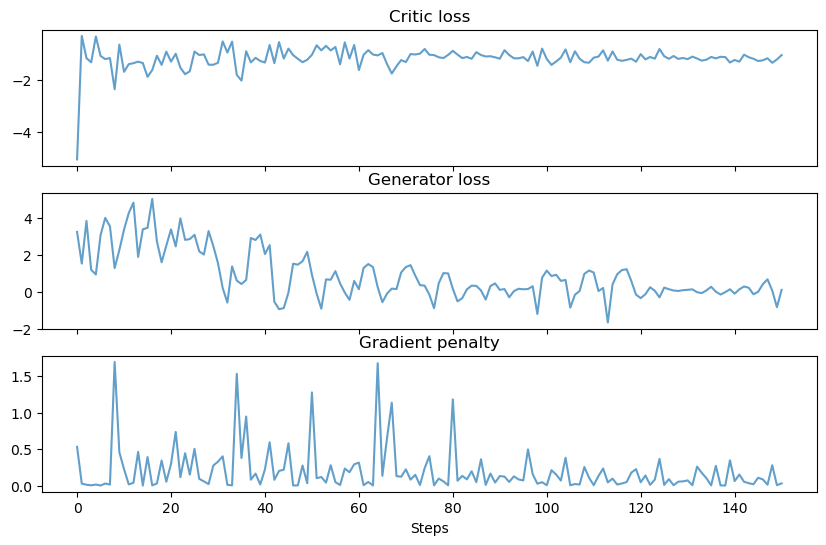

Step 180: g_loss 0.2543 critic_loss -1.2723 critic fake -0.2715  critic_real -1.0008 penalty 0.0911


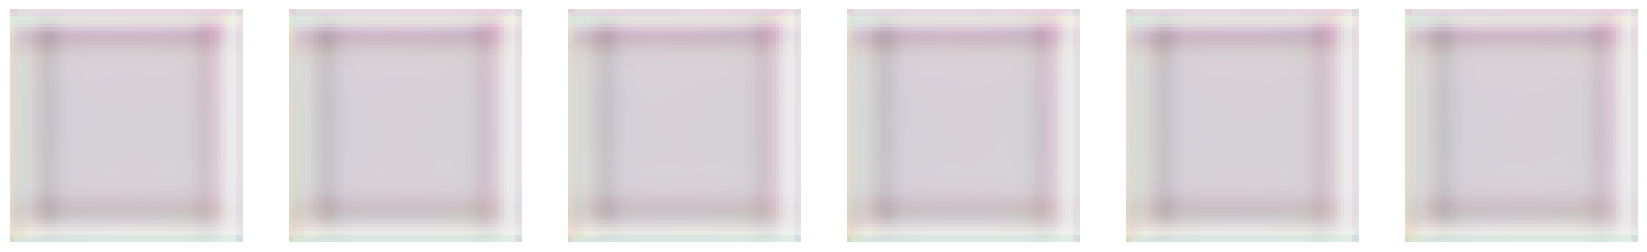

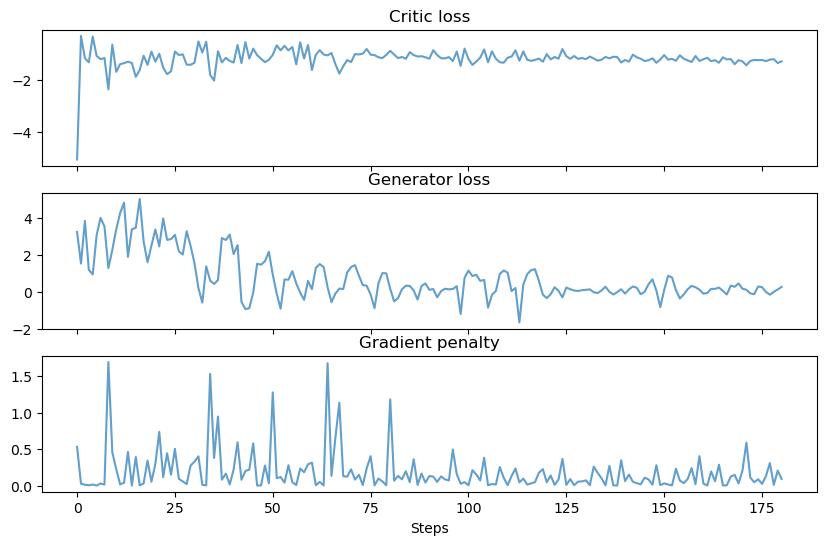

Step 210: g_loss 0.2077 critic_loss -1.2603 critic fake 0.0530  critic_real -1.3133 penalty 0.2436


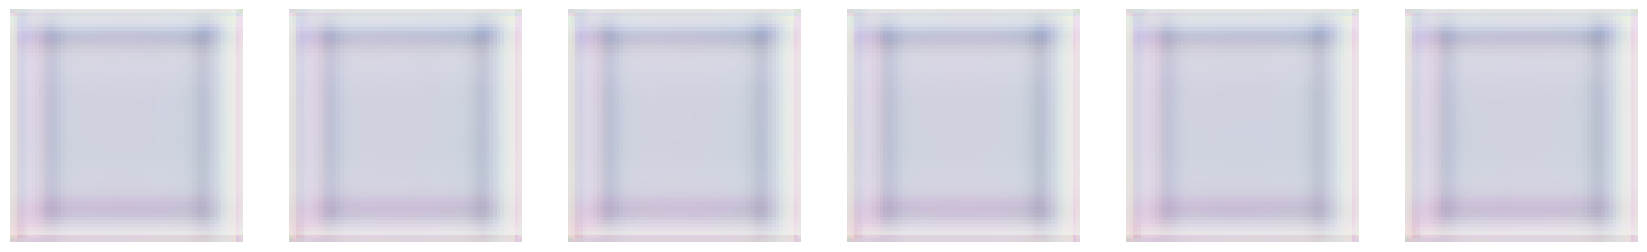

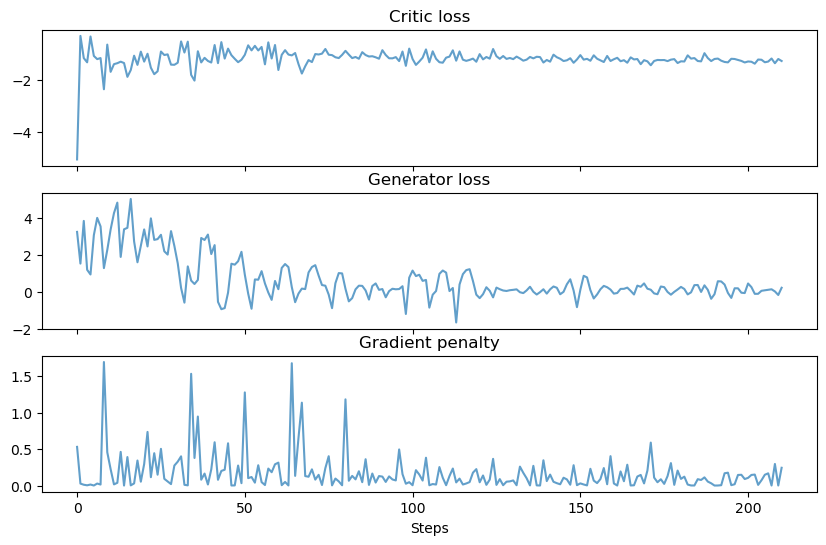

Step 240: g_loss 0.7053 critic_loss -1.0337 critic fake -0.5219  critic_real -0.5118 penalty 0.0014


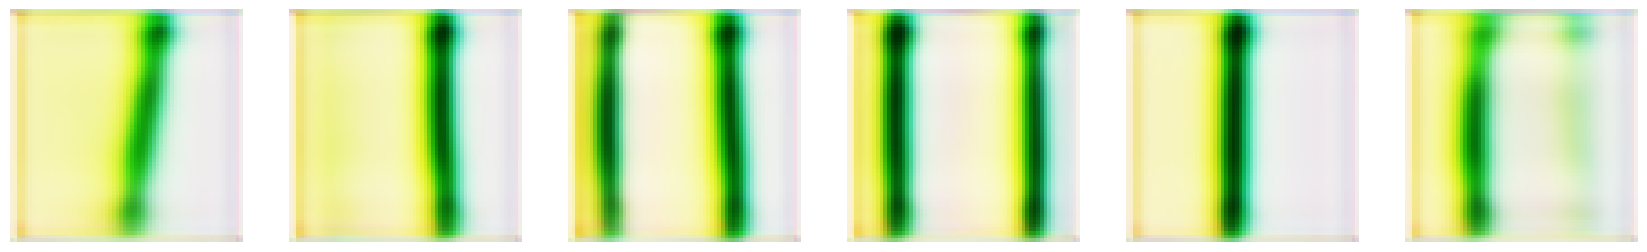

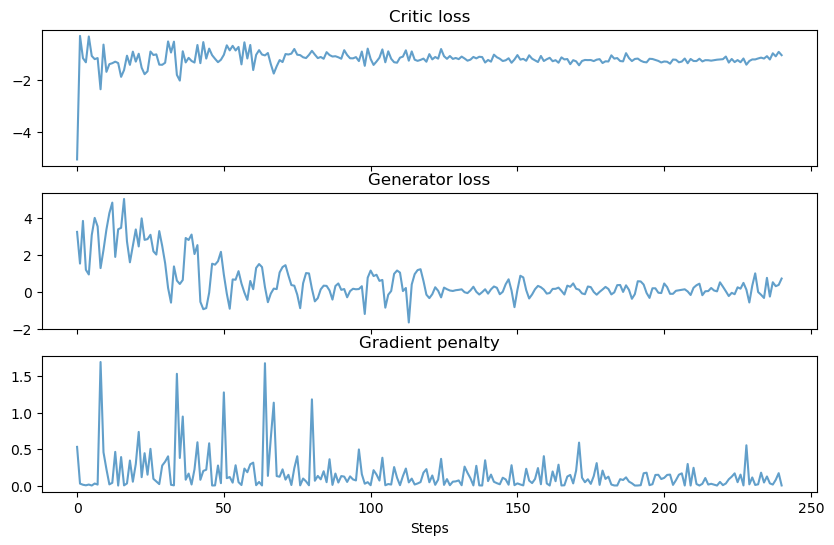

Step 270: g_loss 0.5094 critic_loss -1.1116 critic fake -0.4077  critic_real -0.7039 penalty 0.1498


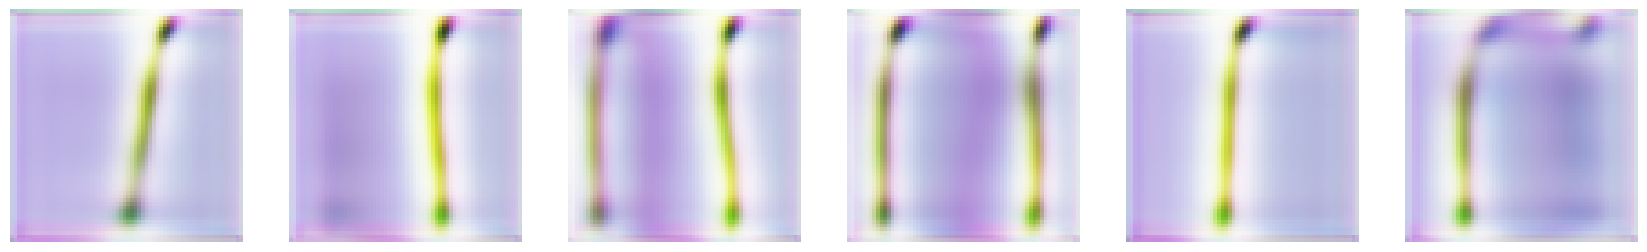

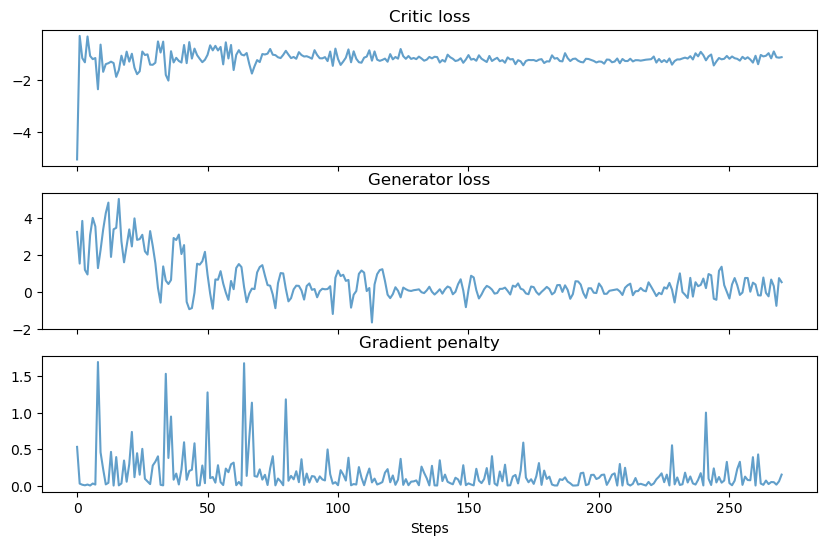

Step 300: g_loss -0.0378 critic_loss -1.0139 critic fake -0.0577  critic_real -0.9561 penalty 0.1092


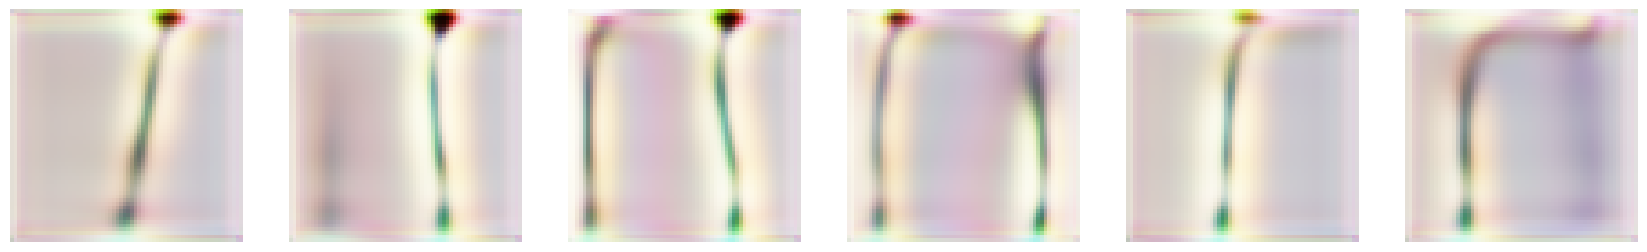

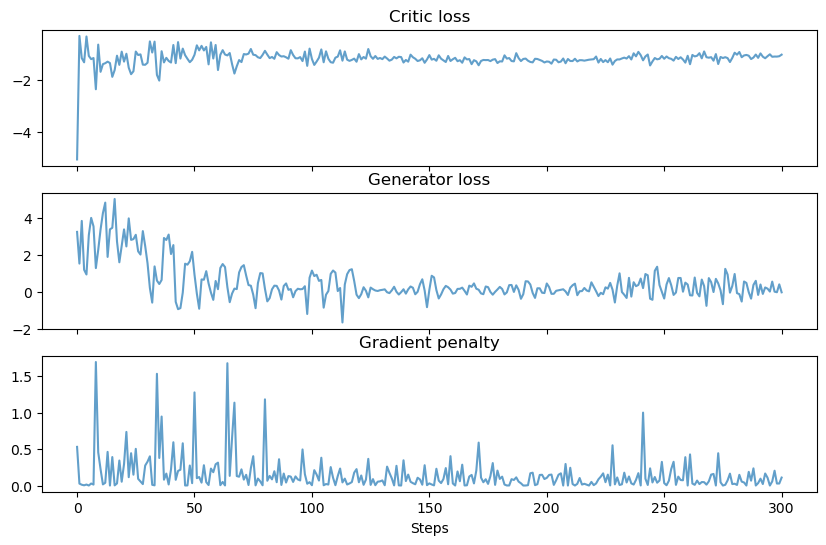

Step 330: g_loss -0.3335 critic_loss -1.0164 critic fake 0.2362  critic_real -1.2526 penalty 0.0029


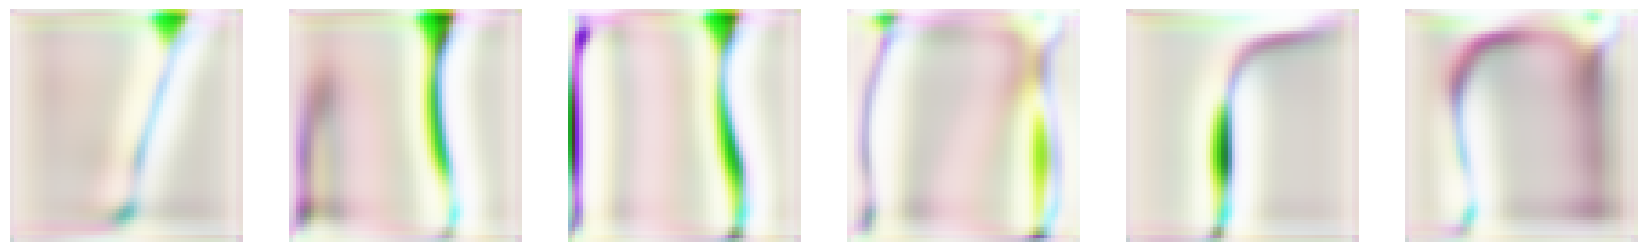

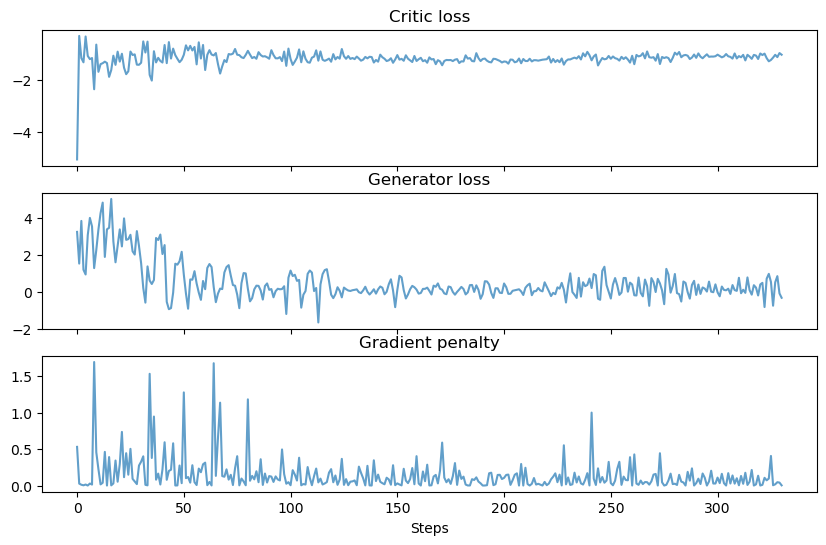

Step 360: g_loss -0.3038 critic_loss -1.1474 critic fake 0.4406  critic_real -1.5880 penalty 0.0912


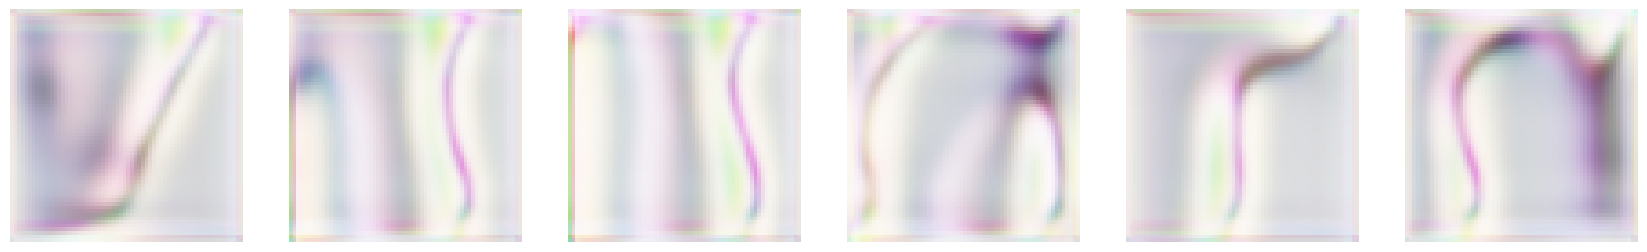

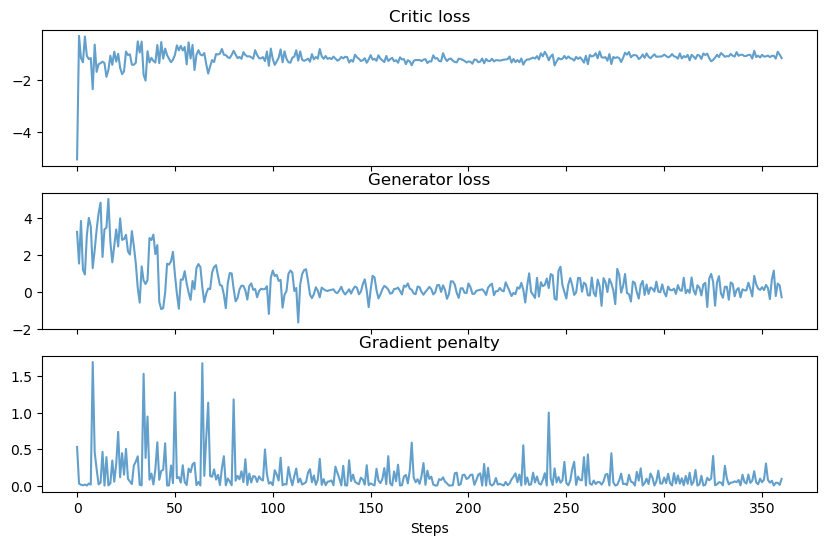

Step 390: g_loss 0.1247 critic_loss -1.0373 critic fake -0.0184  critic_real -1.0189 penalty 0.1082


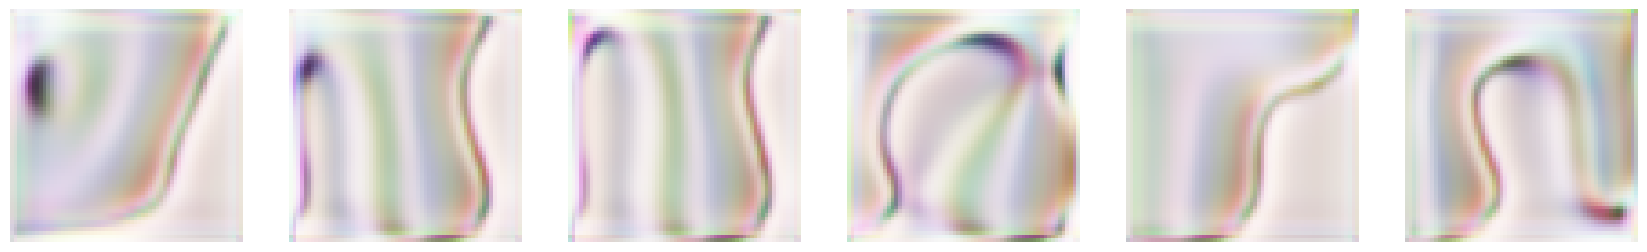

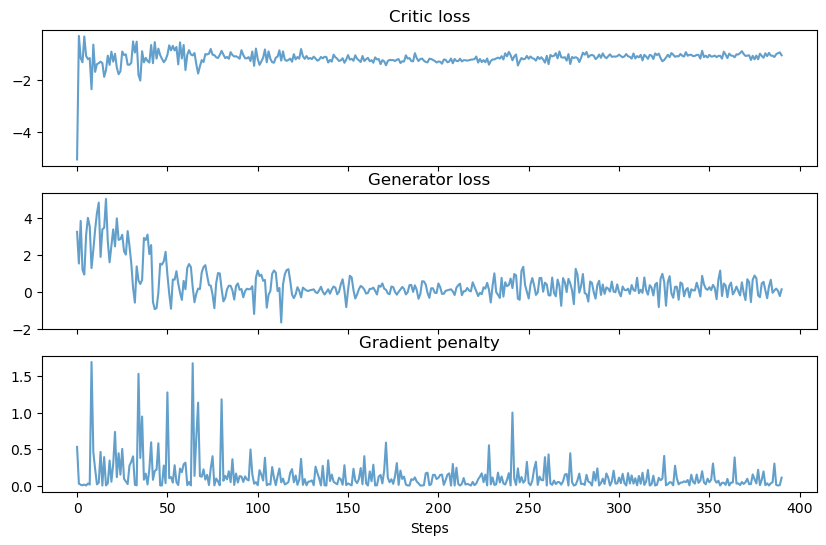

Step 420: g_loss 0.7072 critic_loss -0.9065 critic fake -0.4493  critic_real -0.4572 penalty 0.0527


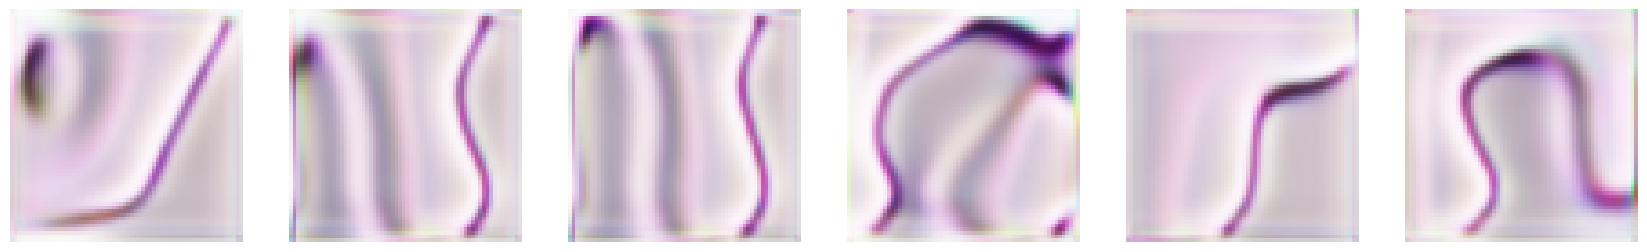

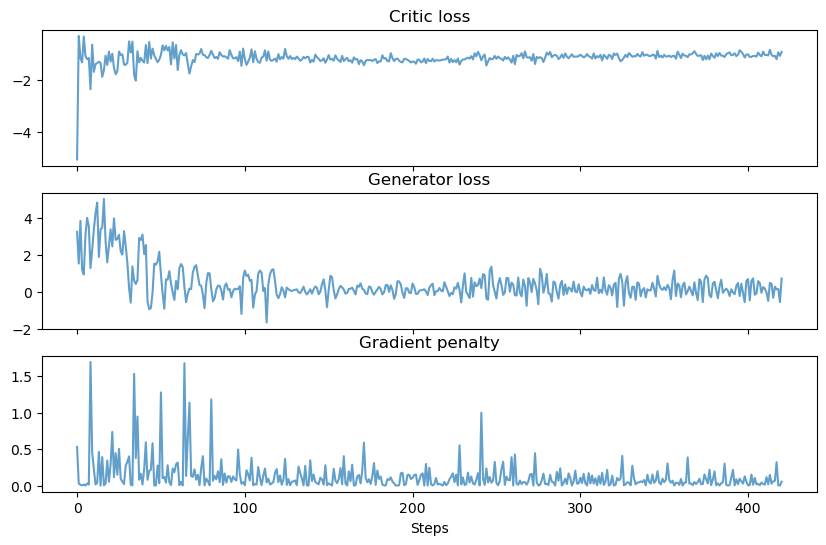

Step 450: g_loss -0.4605 critic_loss -0.9899 critic fake 0.2620  critic_real -1.2519 penalty 0.0000


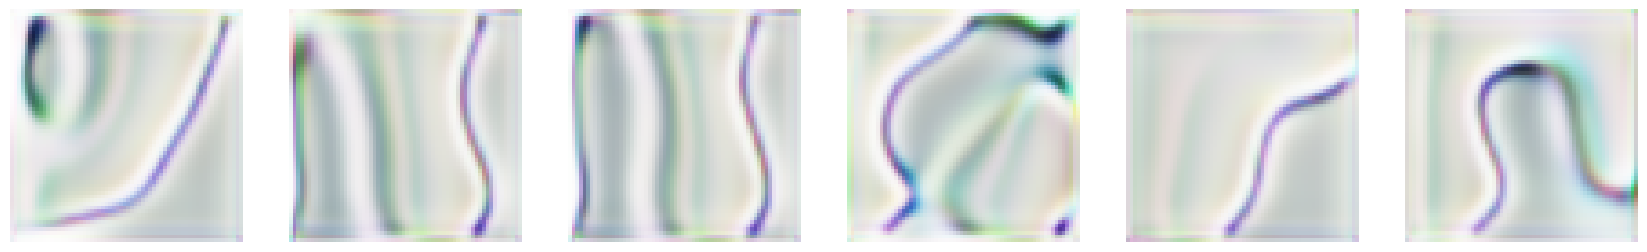

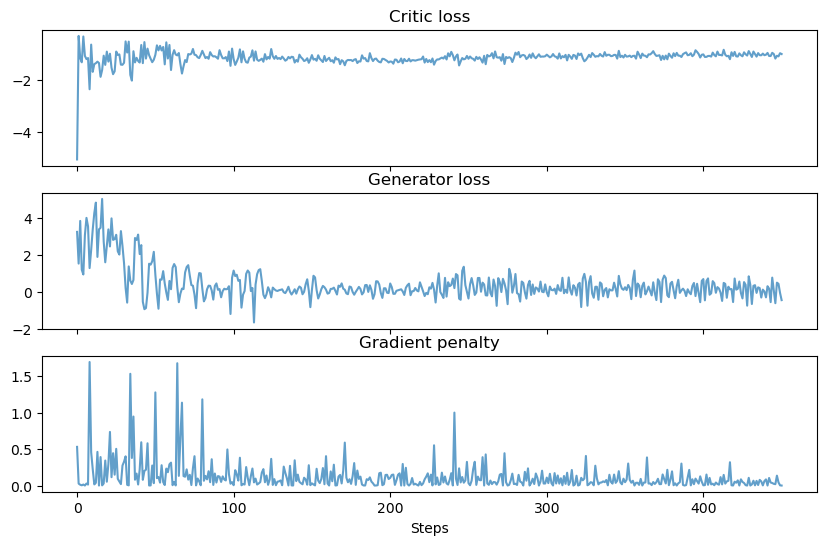

Step 480: g_loss 0.2855 critic_loss -0.9308 critic fake -0.1429  critic_real -0.7879 penalty 0.0070


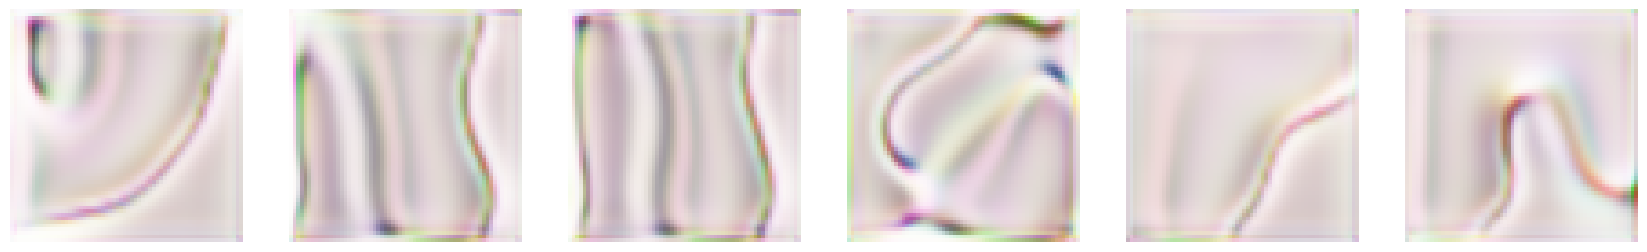

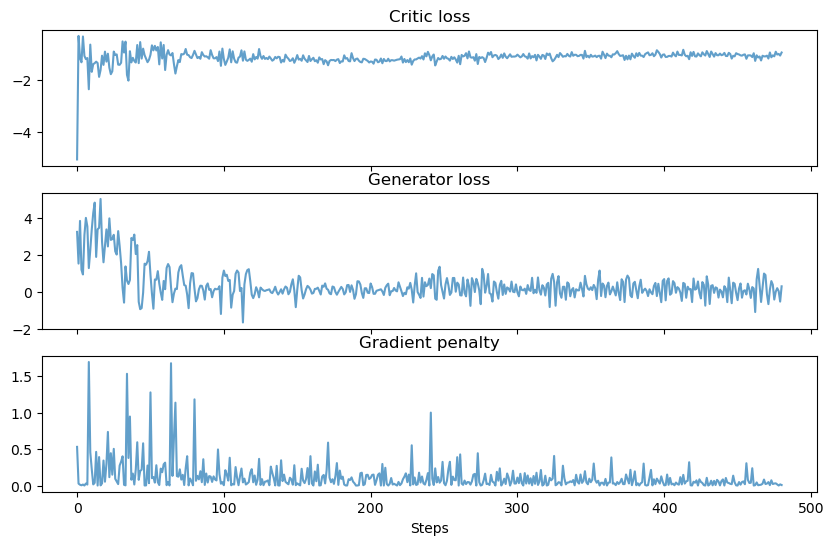

Step 510: g_loss -0.0078 critic_loss -1.0355 critic fake -0.0408  critic_real -0.9947 penalty 0.0169


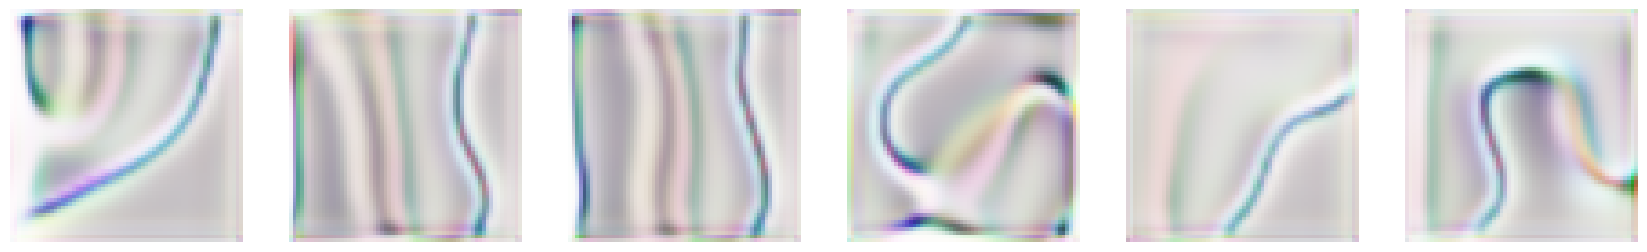

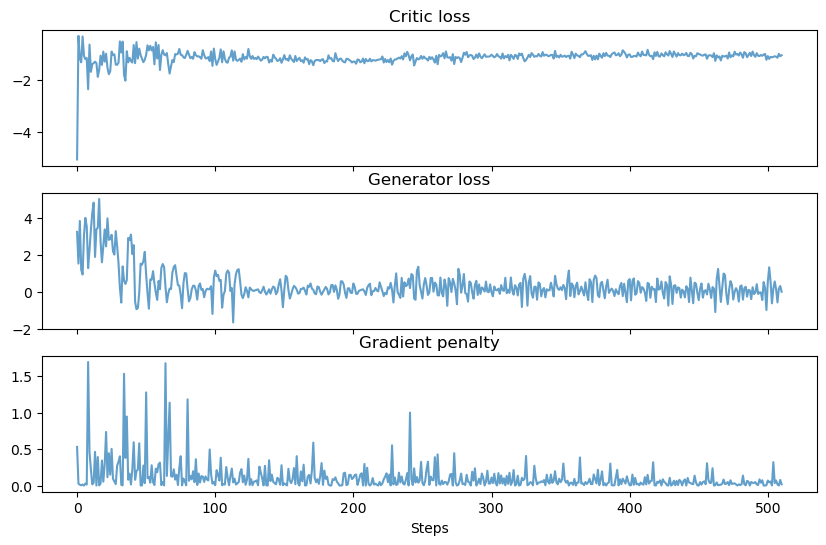

Step 540: g_loss -0.4706 critic_loss -1.1822 critic fake 0.3763  critic_real -1.5584 penalty 0.0483


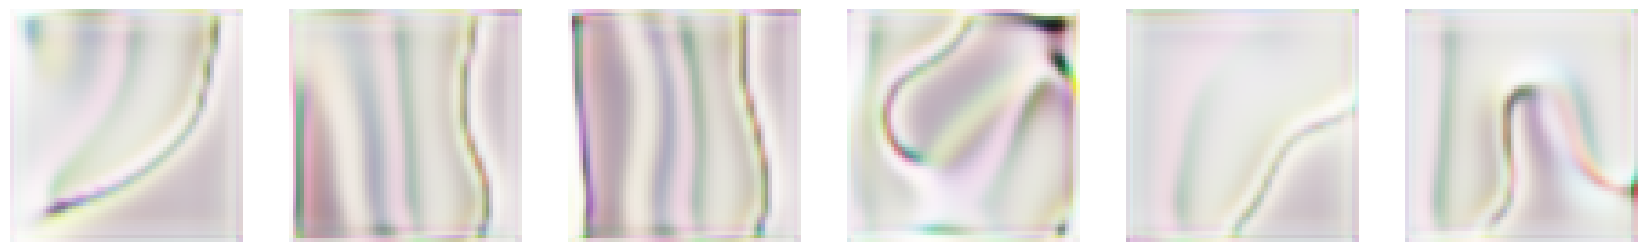

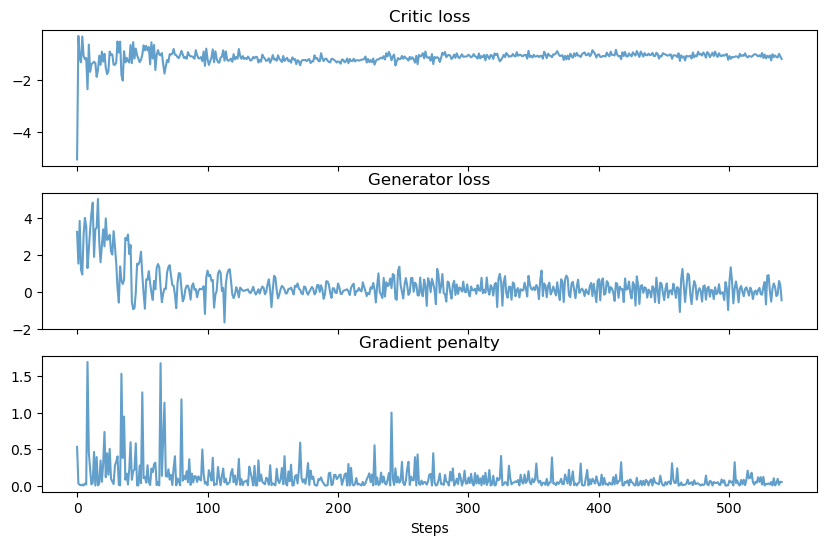

Step 570: g_loss -0.2861 critic_loss -1.1863 critic fake 0.3158  critic_real -1.5021 penalty 0.1157


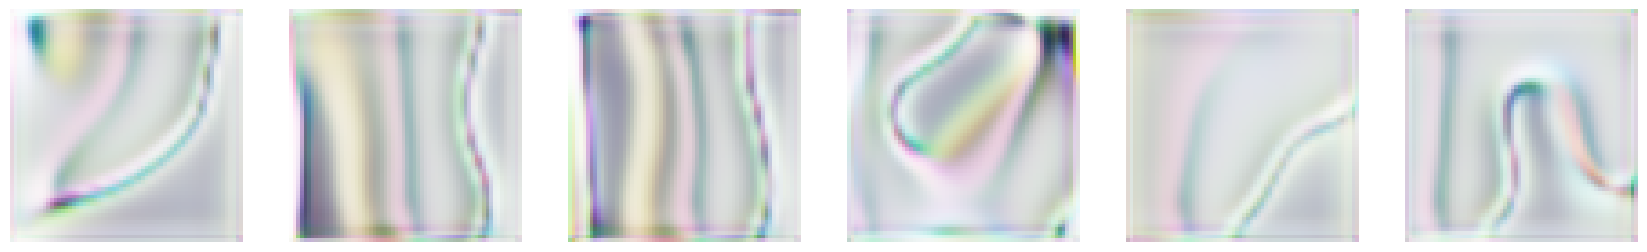

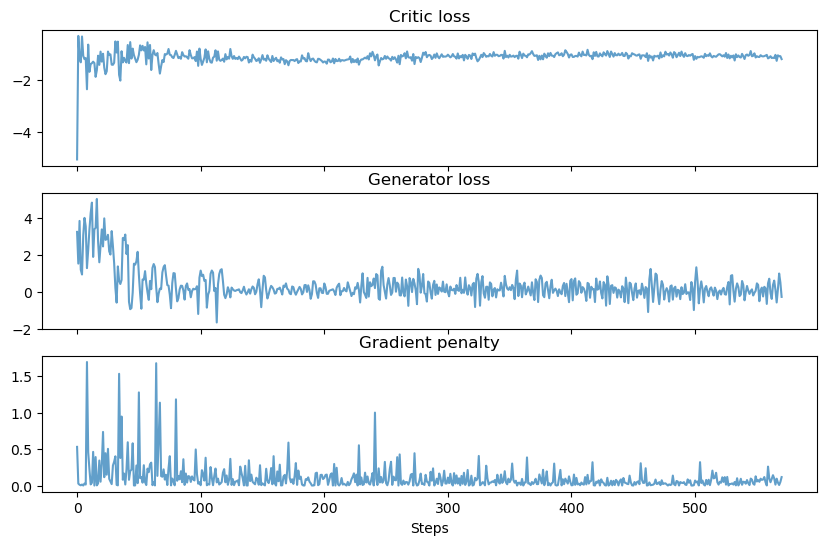

Step 600: g_loss -0.0735 critic_loss -0.9831 critic fake 0.0026  critic_real -0.9856 penalty 0.0000


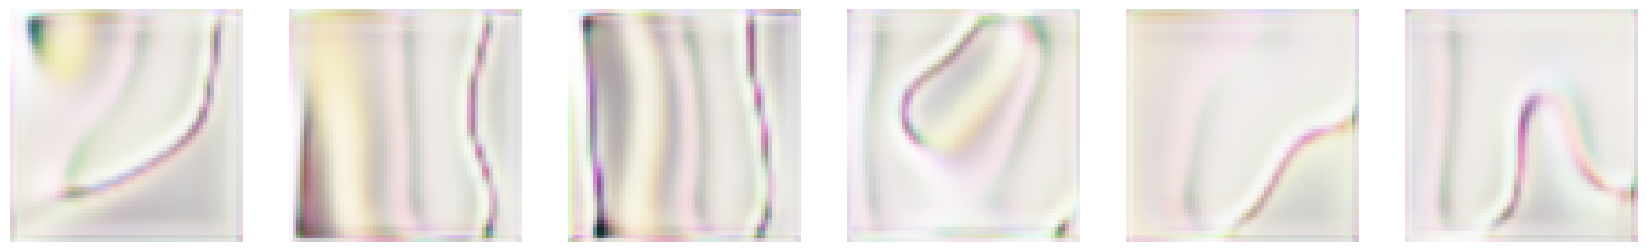

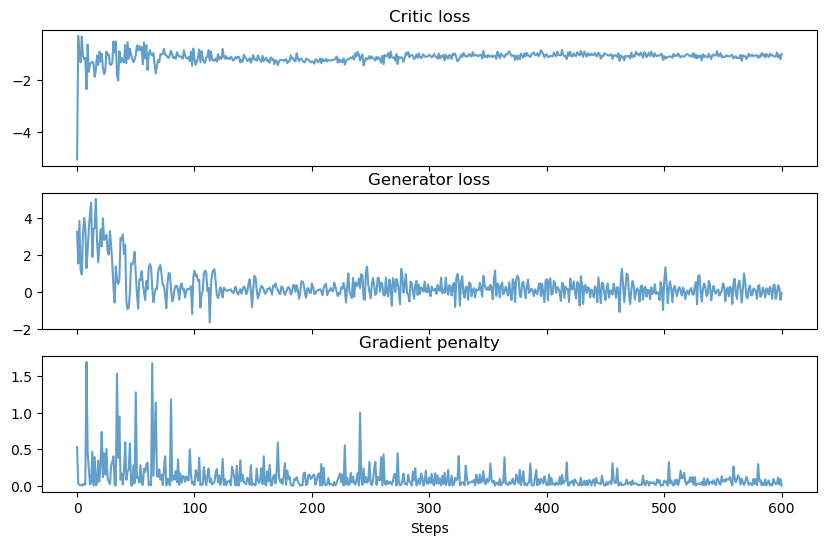

Step 630: g_loss 0.4284 critic_loss -0.9279 critic fake -0.2950  critic_real -0.6329 penalty 0.0223


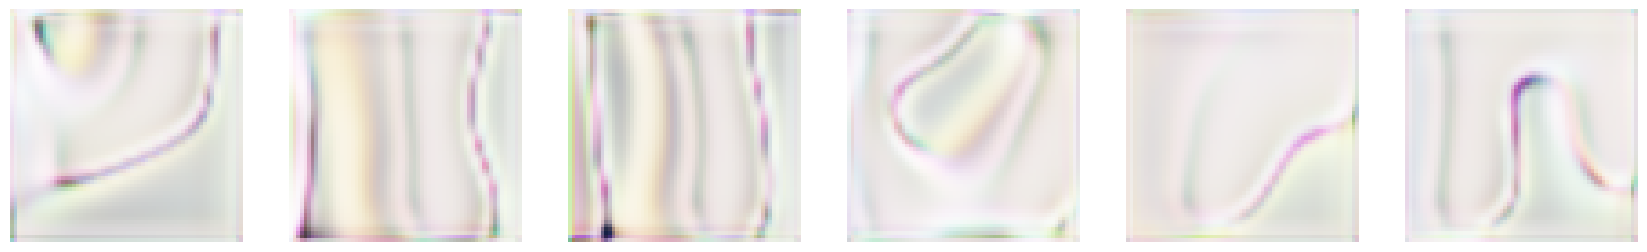

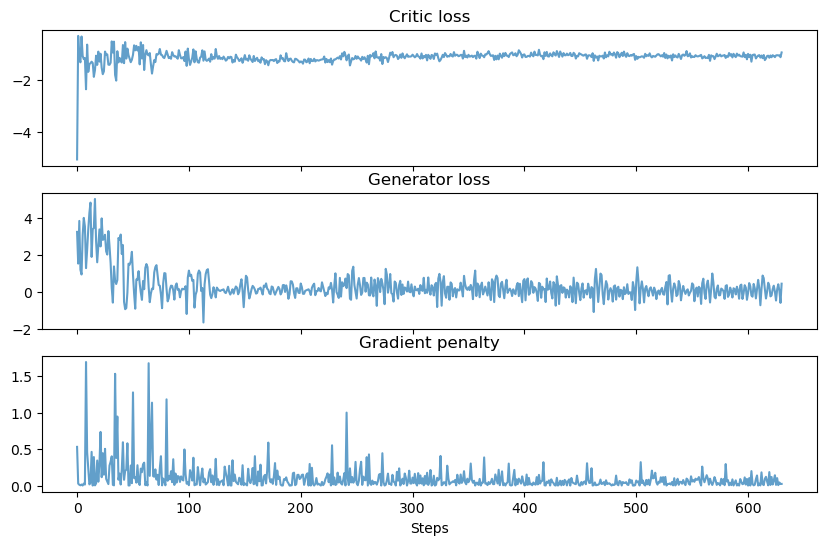

Step 660: g_loss 0.1722 critic_loss -1.0574 critic fake -0.1611  critic_real -0.8963 penalty 0.0363


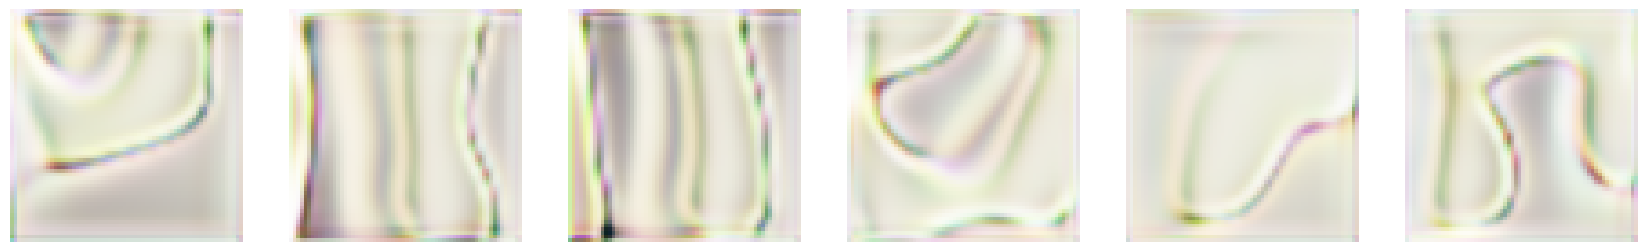

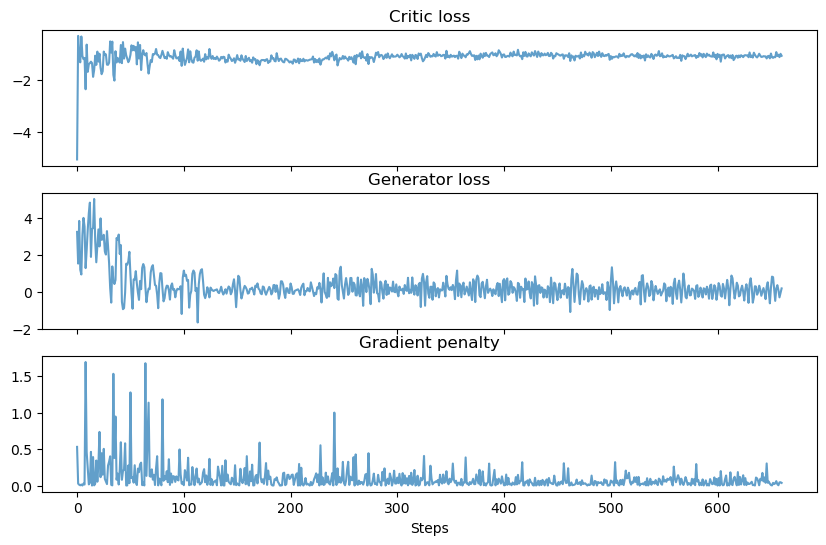

Step 690: g_loss 0.0418 critic_loss -1.0429 critic fake -0.1022  critic_real -0.9407 penalty 0.0319


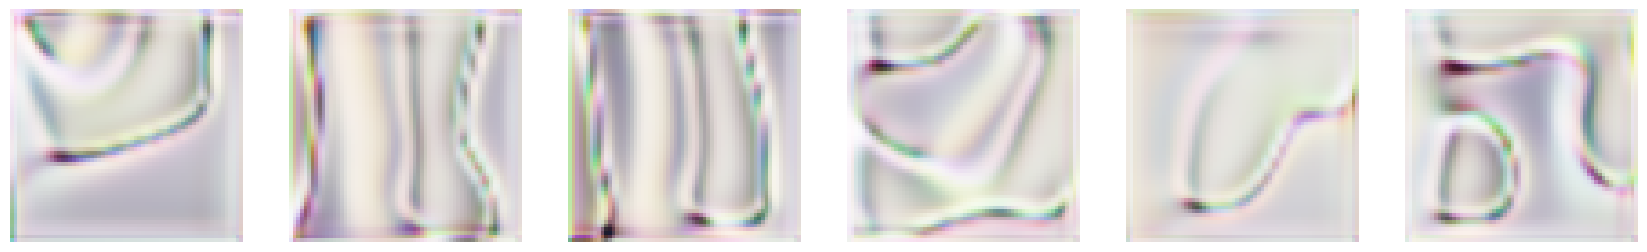

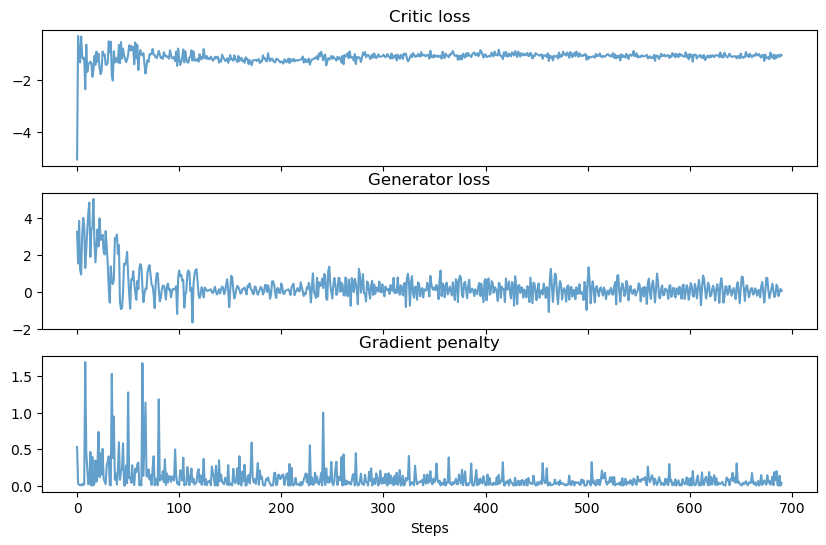

Step 720: g_loss -0.1640 critic_loss -1.0925 critic fake 0.0965  critic_real -1.1889 penalty 0.0553


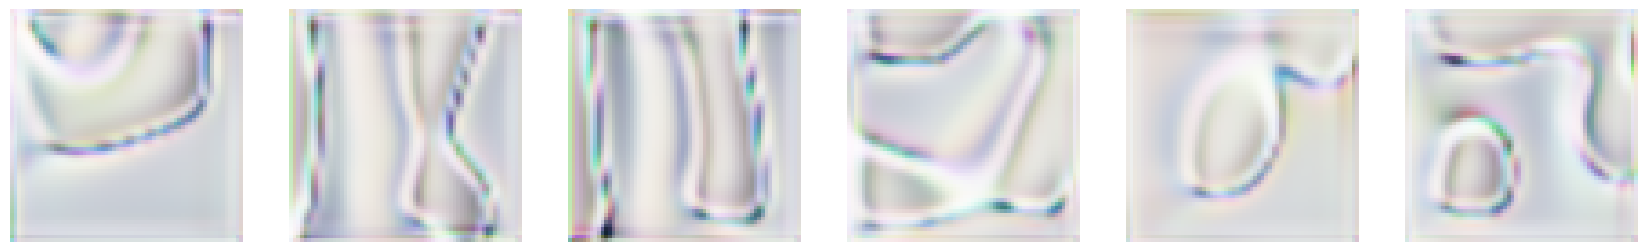

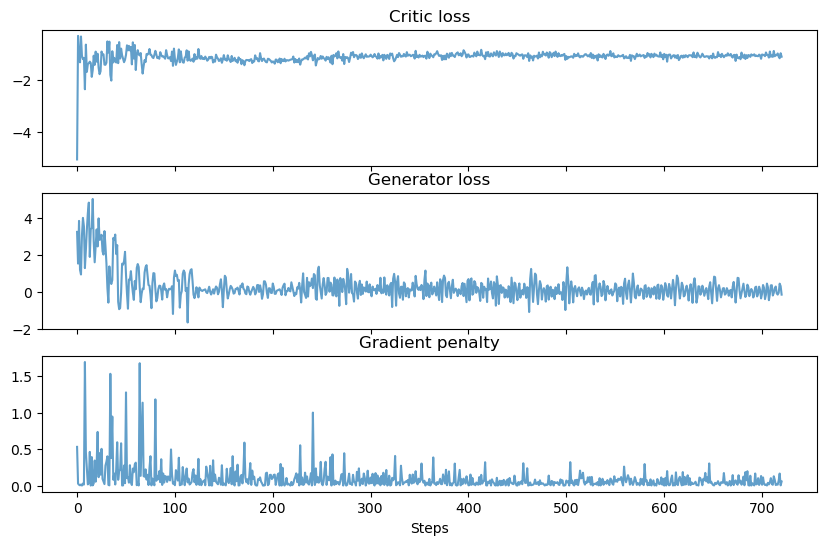

Step 750: g_loss 0.1793 critic_loss -0.9282 critic fake -0.1328  critic_real -0.7954 penalty 0.0121


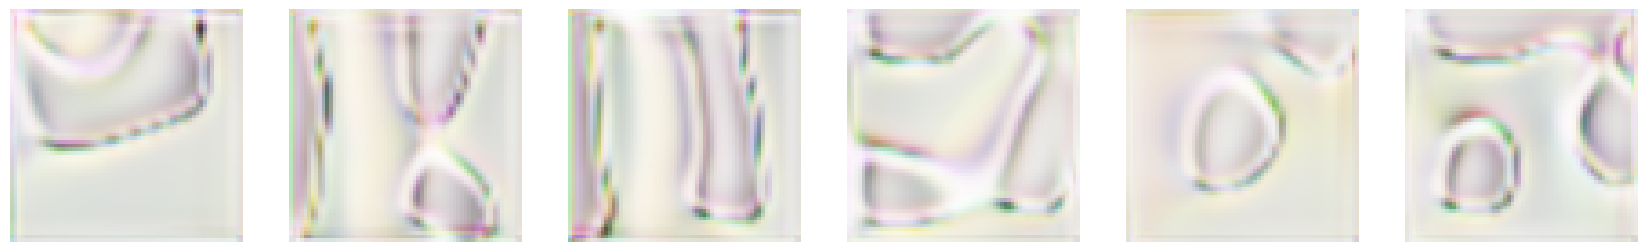

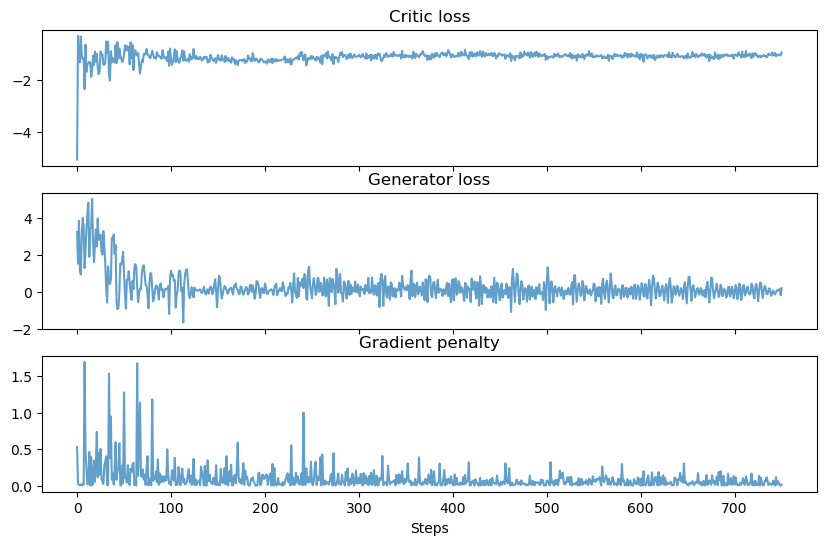

Step 780: g_loss -0.1091 critic_loss -1.0321 critic fake 0.0455  critic_real -1.0776 penalty 0.0284


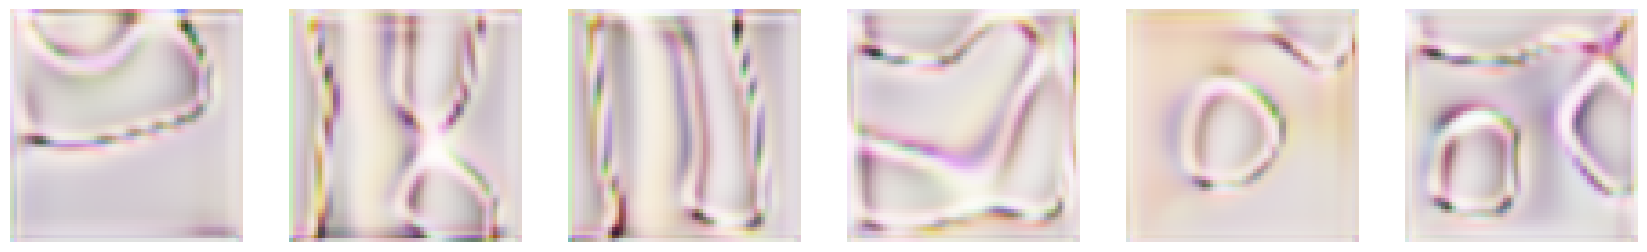

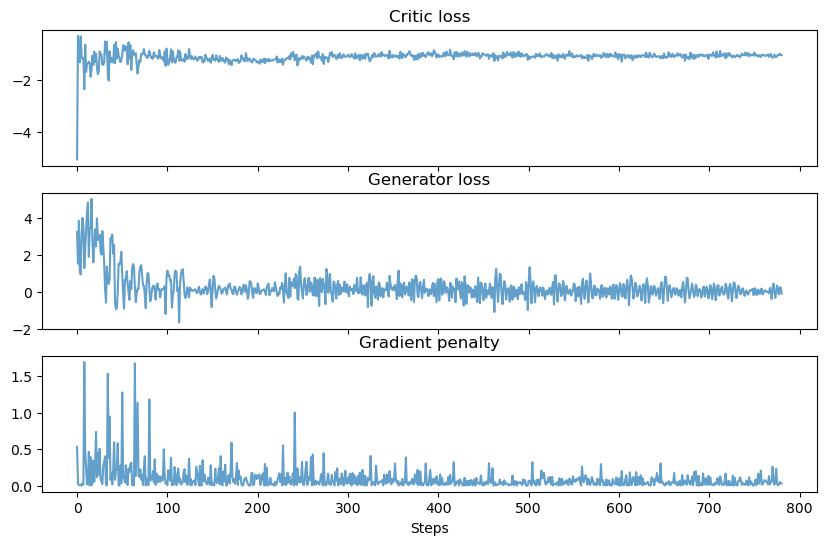

Step 810: g_loss 0.2932 critic_loss -1.1091 critic fake -0.1930  critic_real -0.9161 penalty 0.1119


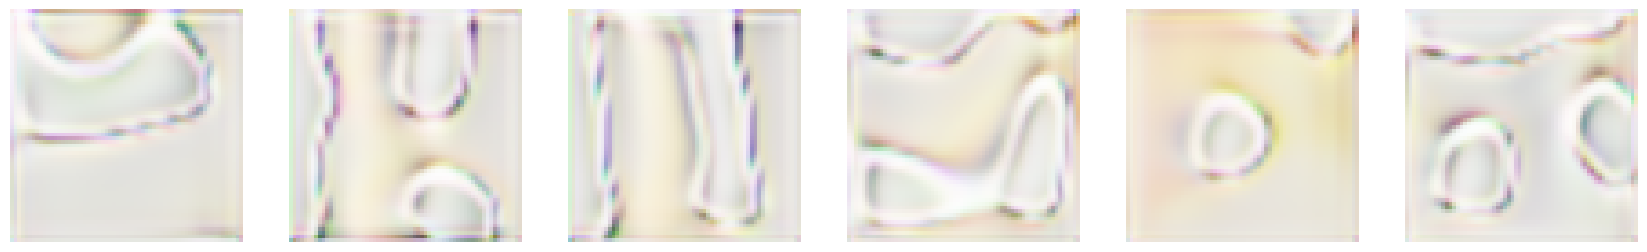

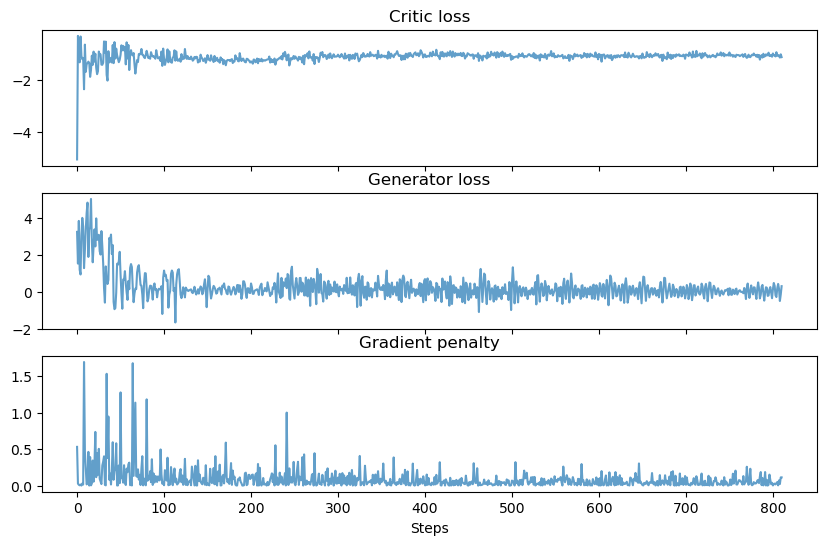

Step 840: g_loss -0.2051 critic_loss -1.0919 critic fake 0.2728  critic_real -1.3647 penalty 0.0886


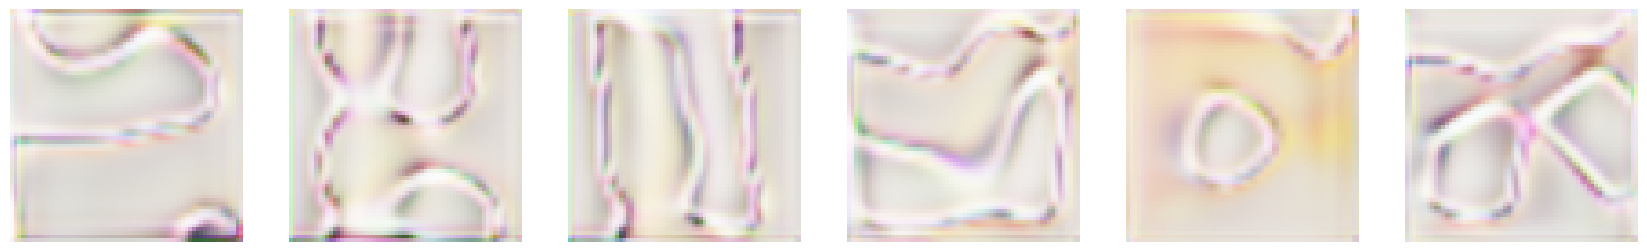

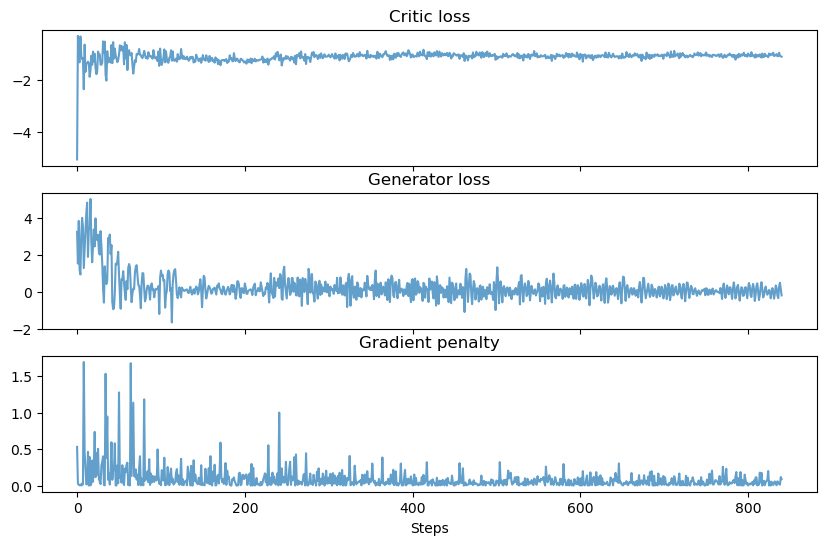

Step 870: g_loss -0.1034 critic_loss -1.0806 critic fake 0.3369  critic_real -1.4175 penalty 0.1381


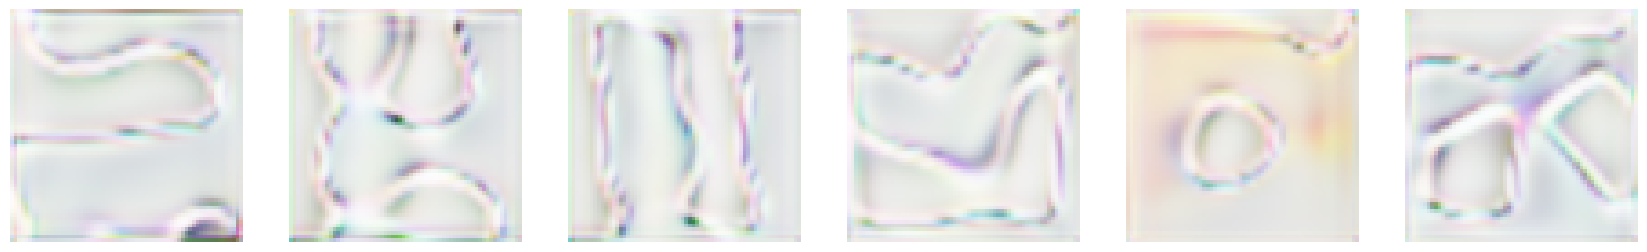

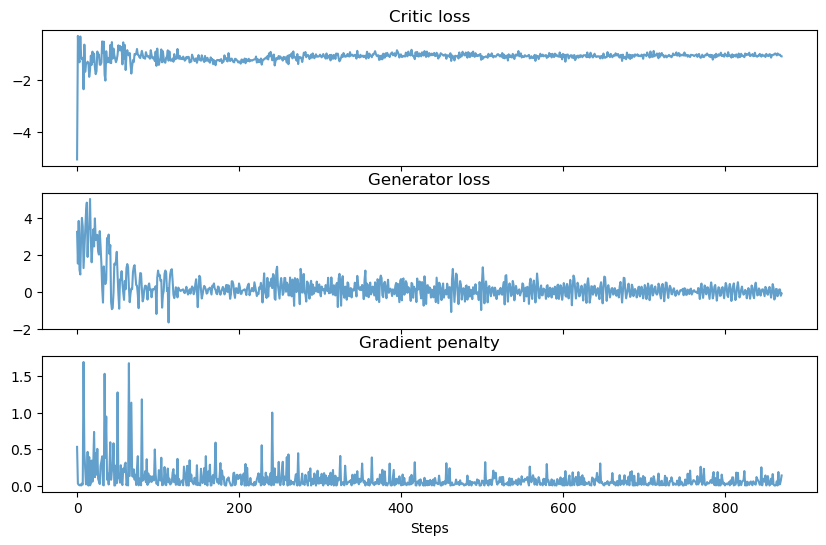

Step 900: g_loss 0.1281 critic_loss -1.0101 critic fake -0.1324  critic_real -0.8777 penalty 0.0162


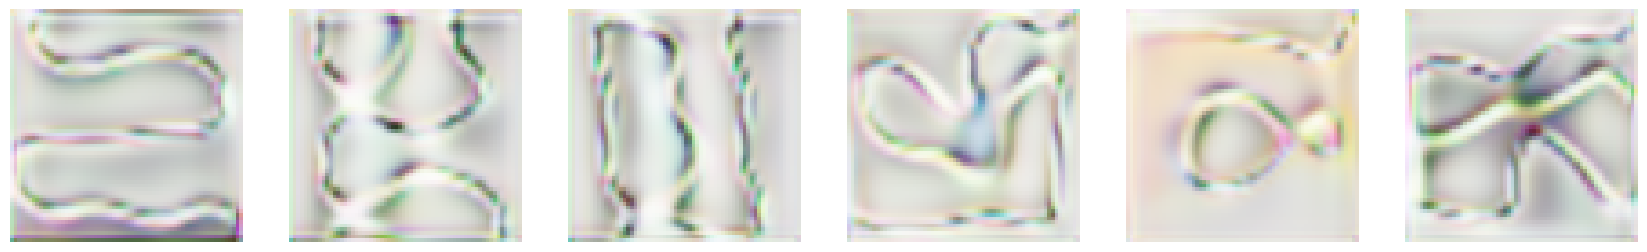

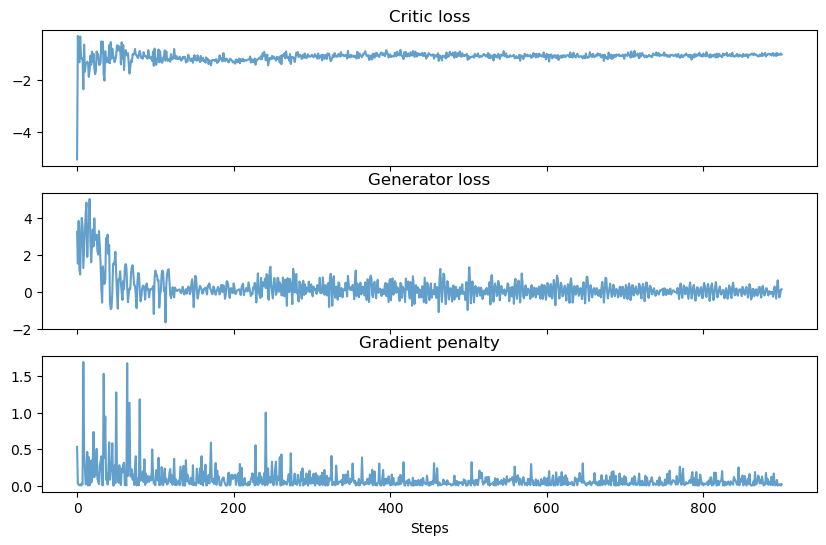

Step 930: g_loss 0.2236 critic_loss -0.9586 critic fake -0.1303  critic_real -0.8283 penalty 0.0001


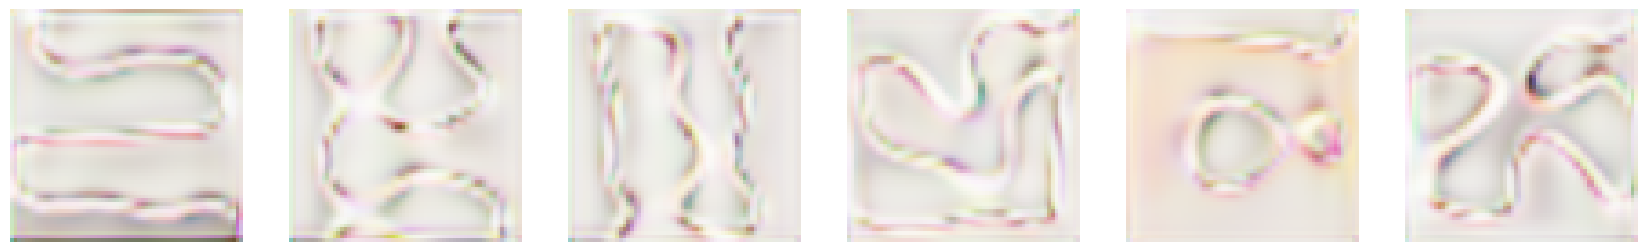

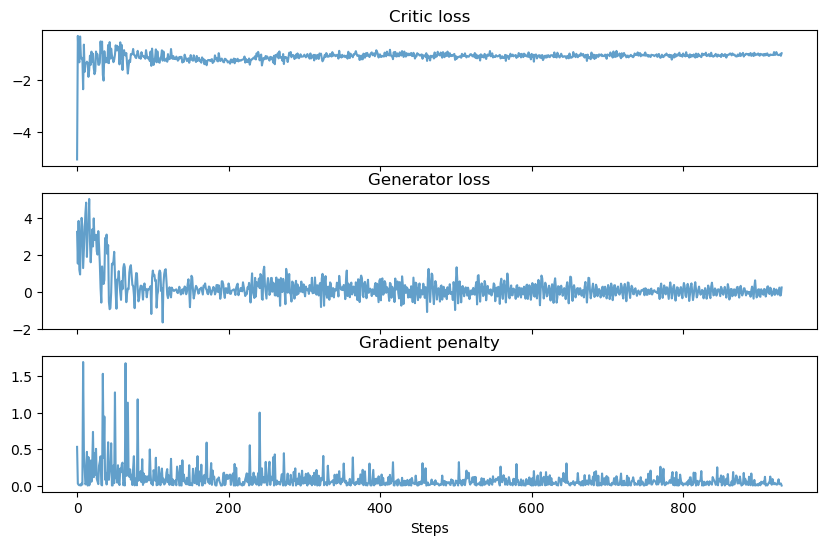

Step 960: g_loss -0.2818 critic_loss -1.0428 critic fake 0.2791  critic_real -1.3219 penalty 0.0336


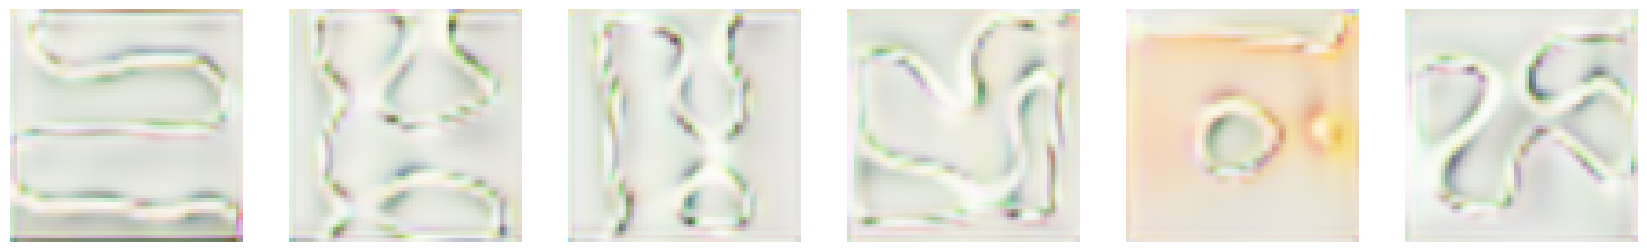

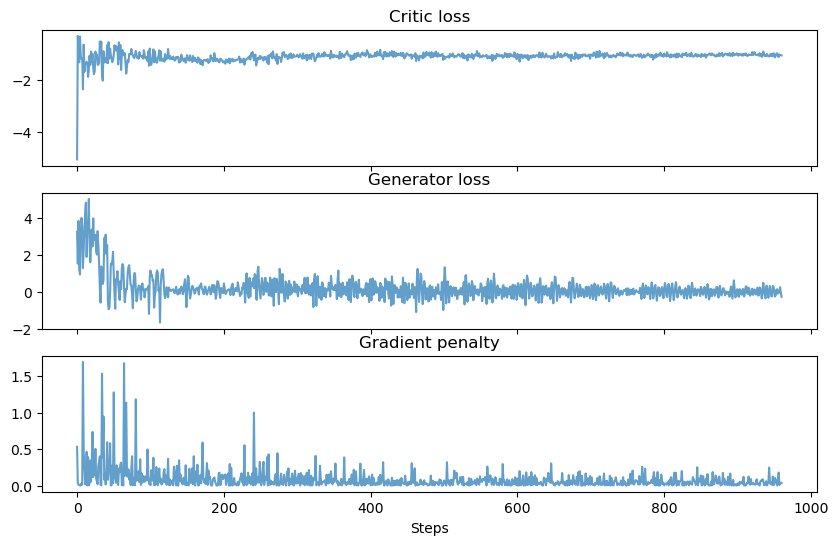

Step 990: g_loss 0.1006 critic_loss -1.0059 critic fake -0.1165  critic_real -0.8894 penalty 0.0151


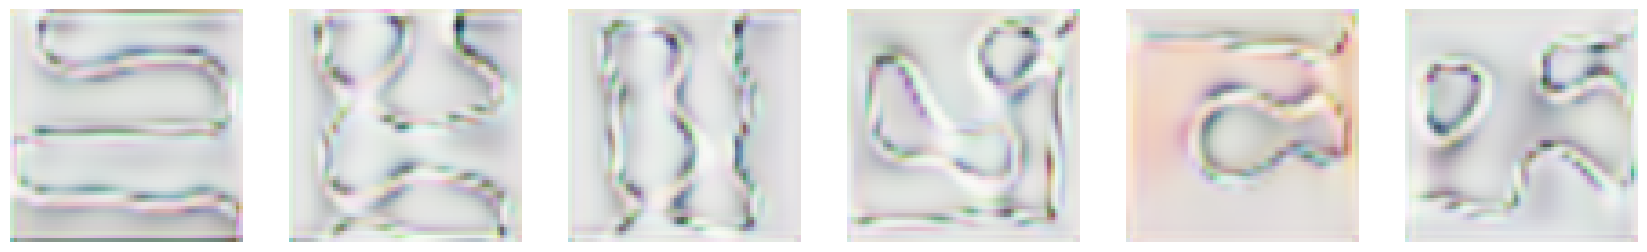

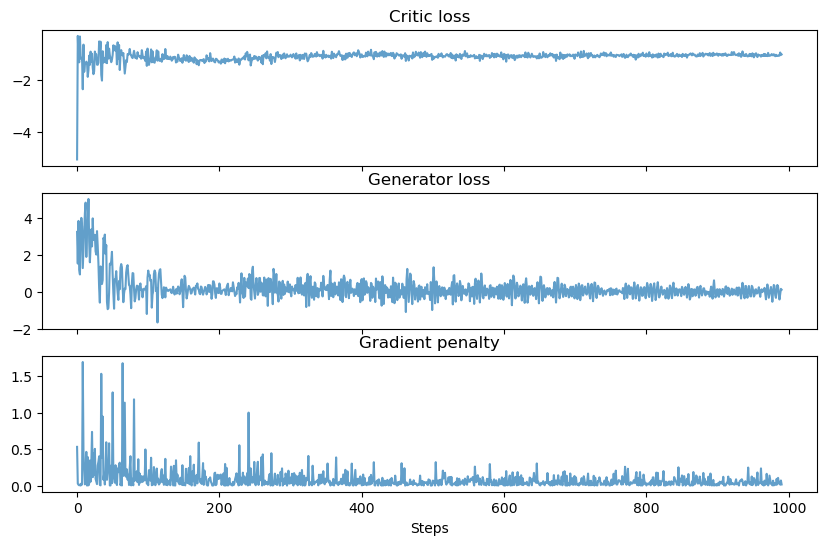

Step 1020: g_loss -0.1425 critic_loss -1.0008 critic fake 0.0944  critic_real -1.0951 penalty 0.0125


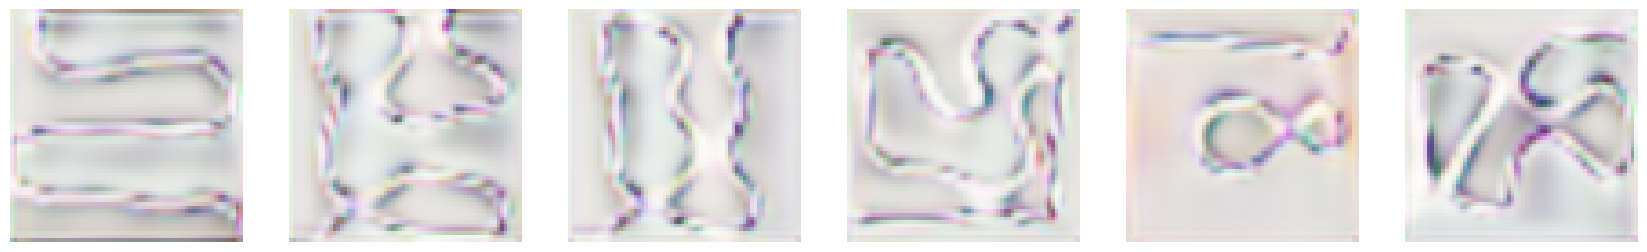

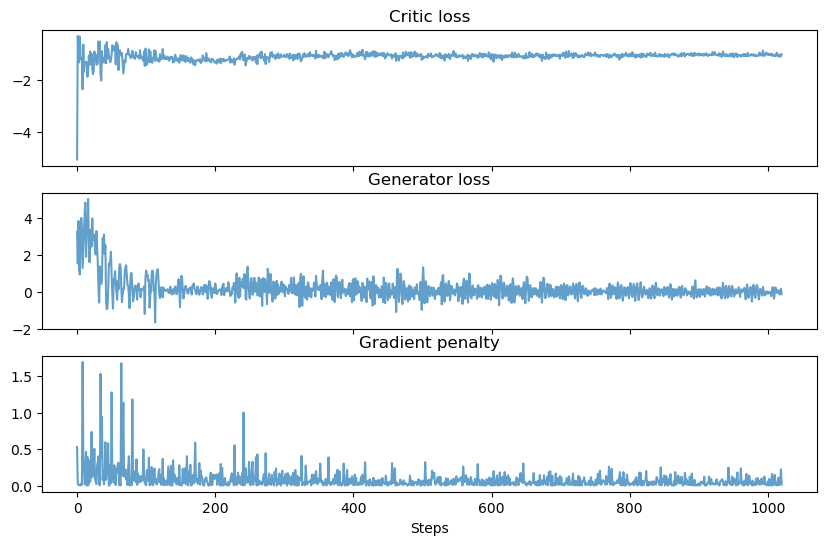

Step 1050: g_loss -0.2702 critic_loss -0.9594 critic fake 0.1641  critic_real -1.1234 penalty 0.0001


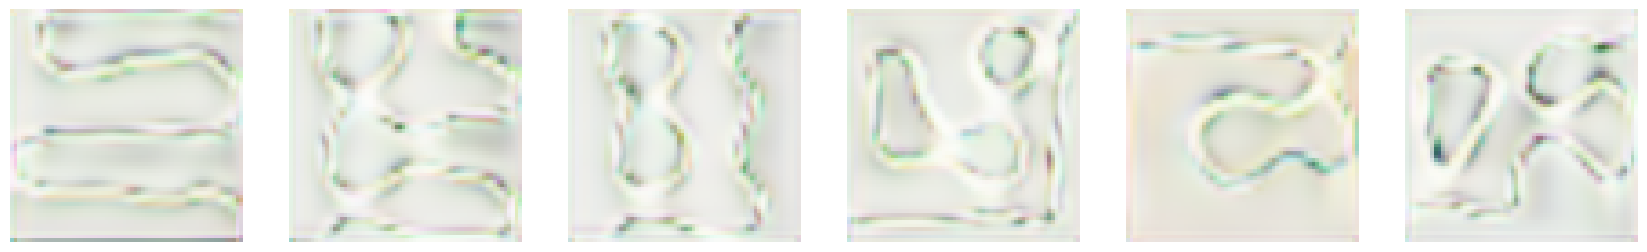

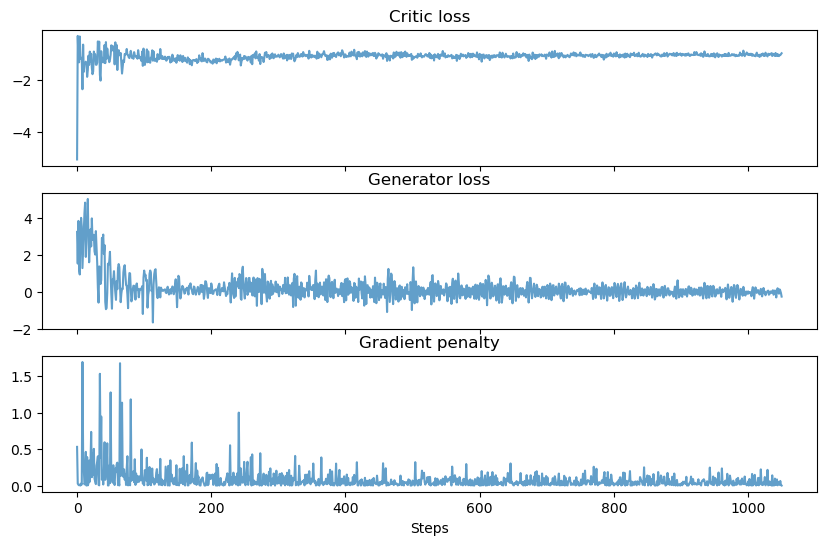

Step 1080: g_loss 0.0129 critic_loss -1.0790 critic fake 0.1714  critic_real -1.2504 penalty 0.0754


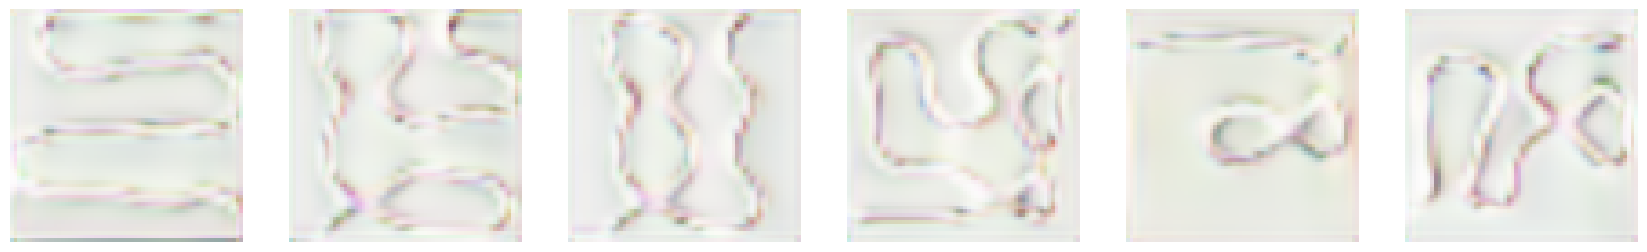

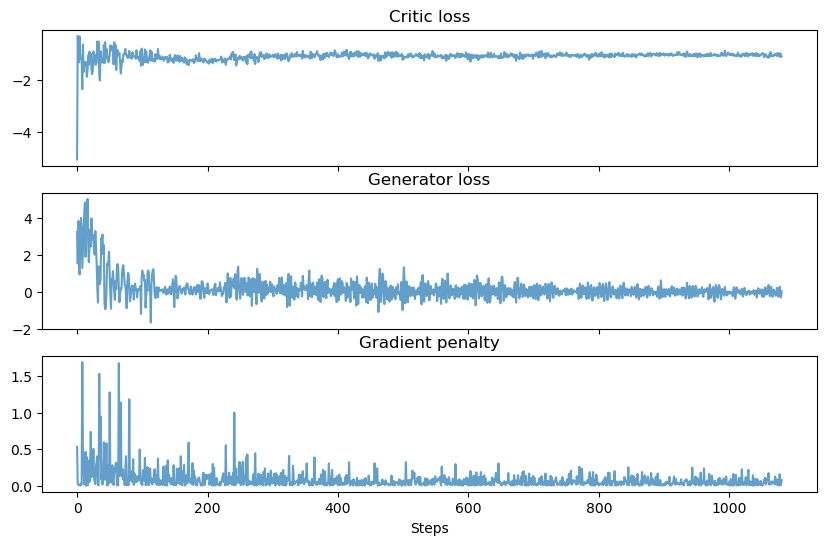

Step 1110: g_loss -0.0692 critic_loss -1.0601 critic fake 0.1031  critic_real -1.1631 penalty 0.0803


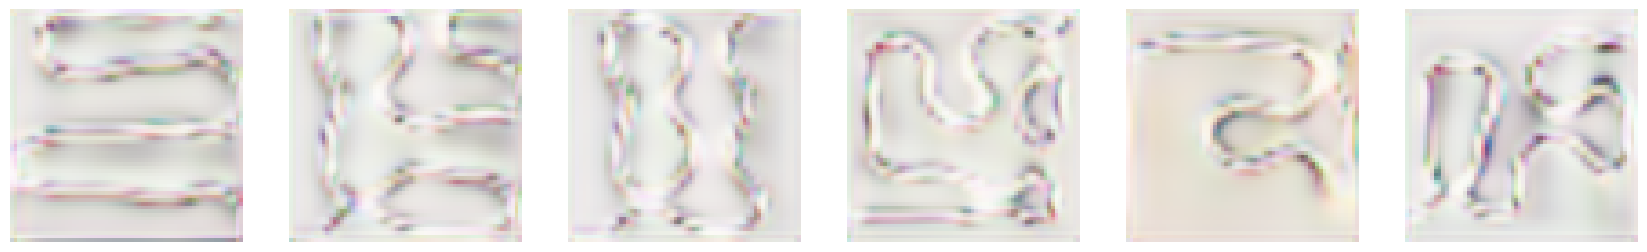

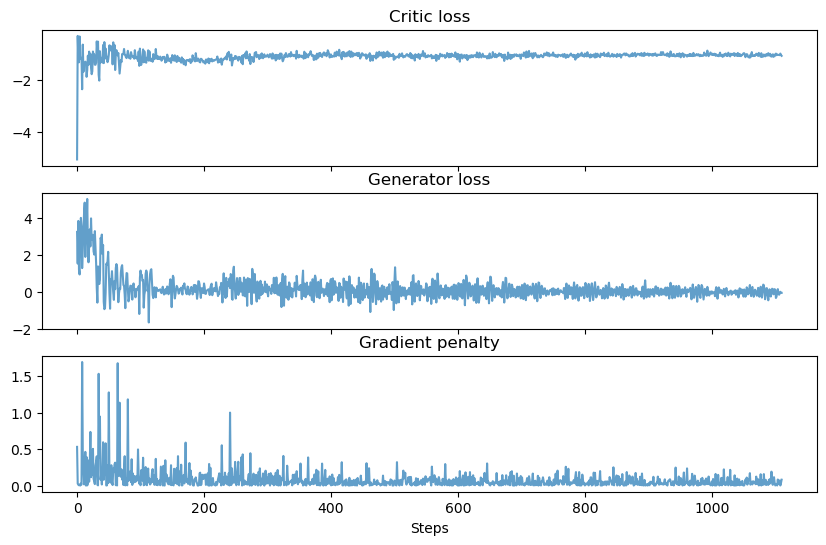

Step 1140: g_loss -0.0003 critic_loss -1.0829 critic fake 0.0740  critic_real -1.1569 penalty 0.1505


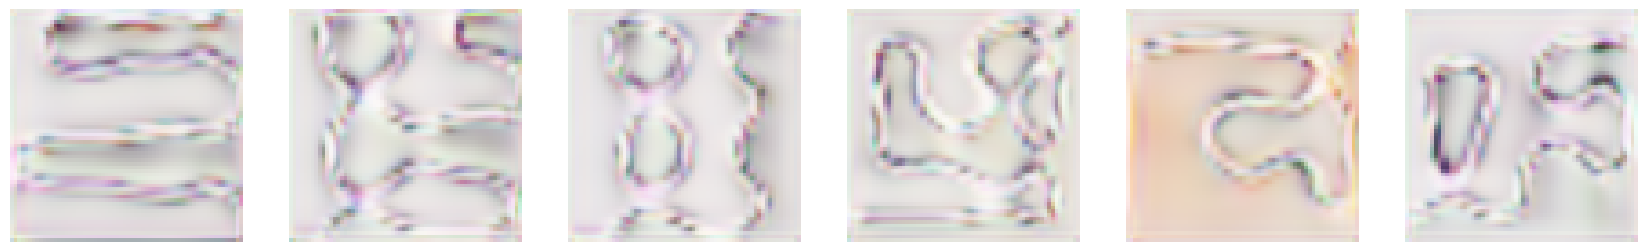

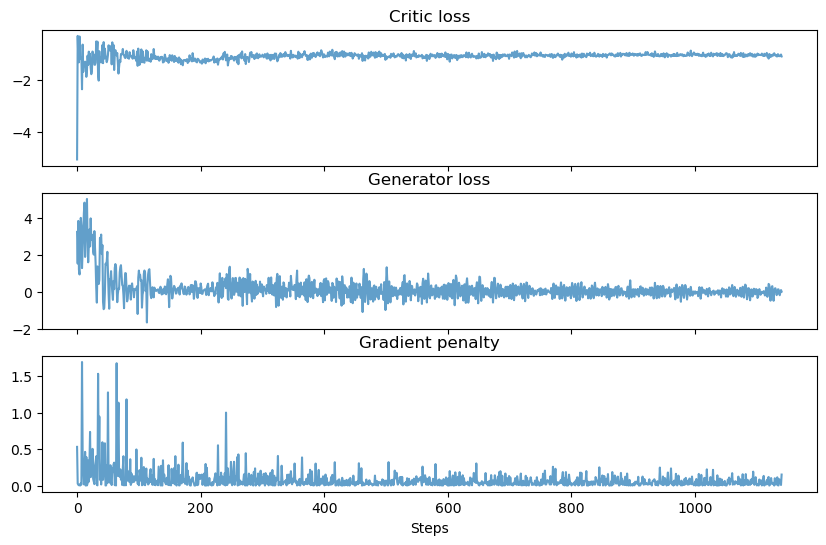

Step 1170: g_loss -0.1706 critic_loss -1.0162 critic fake 0.1008  critic_real -1.1169 penalty 0.0064


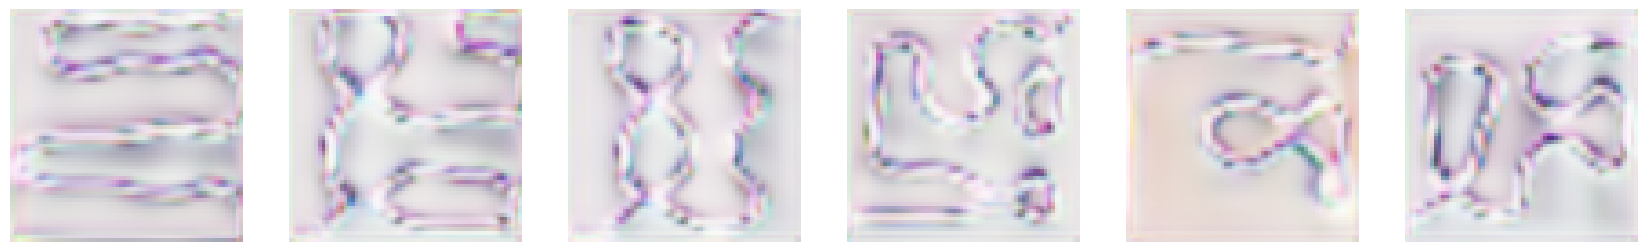

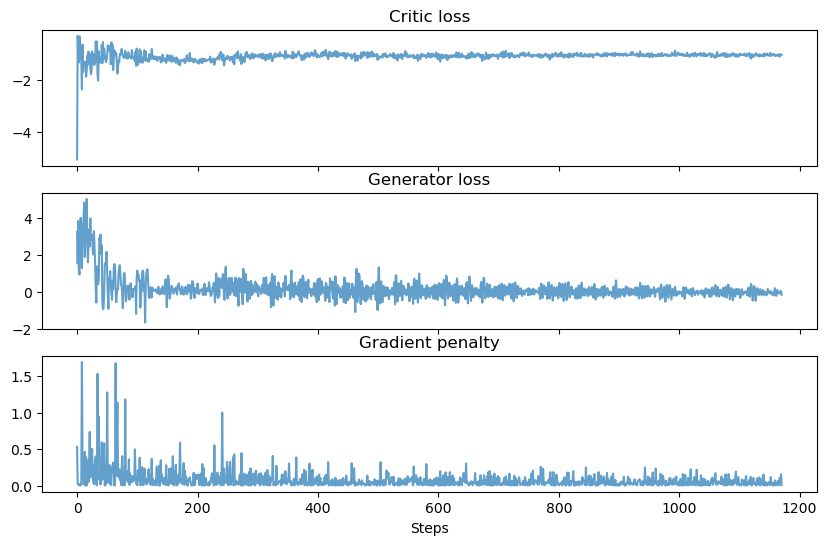

Step 1200: g_loss -0.0417 critic_loss -1.0430 critic fake 0.0394  critic_real -1.0824 penalty 0.0334


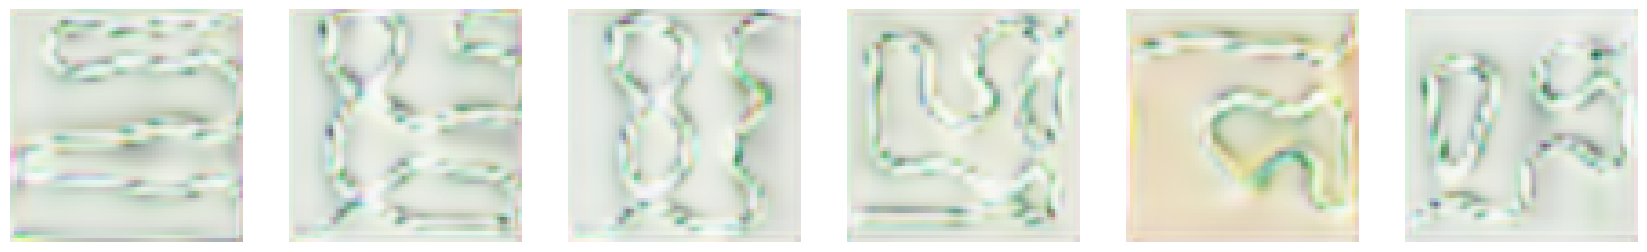

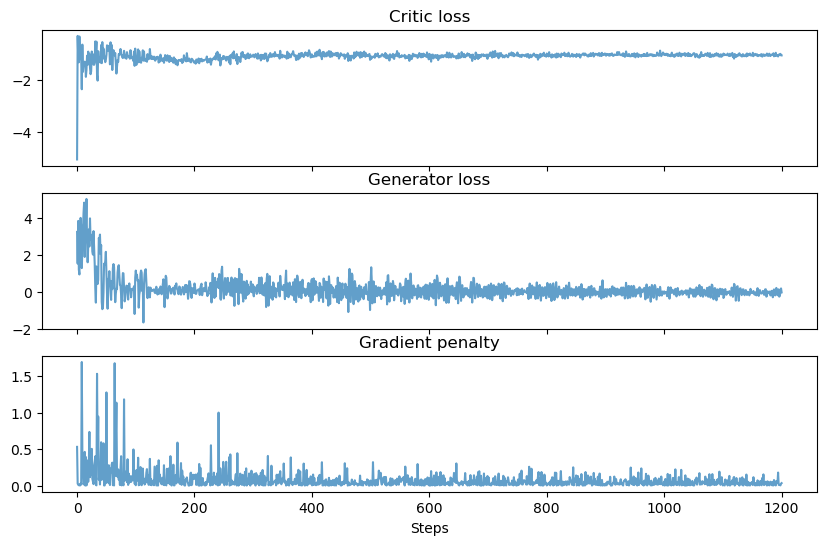

Step 1230: g_loss -0.0549 critic_loss -0.9726 critic fake 0.0578  critic_real -1.0304 penalty 0.0011


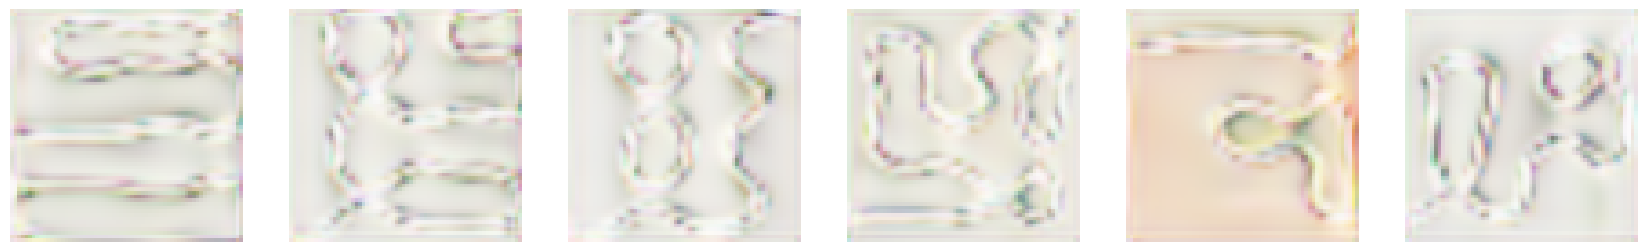

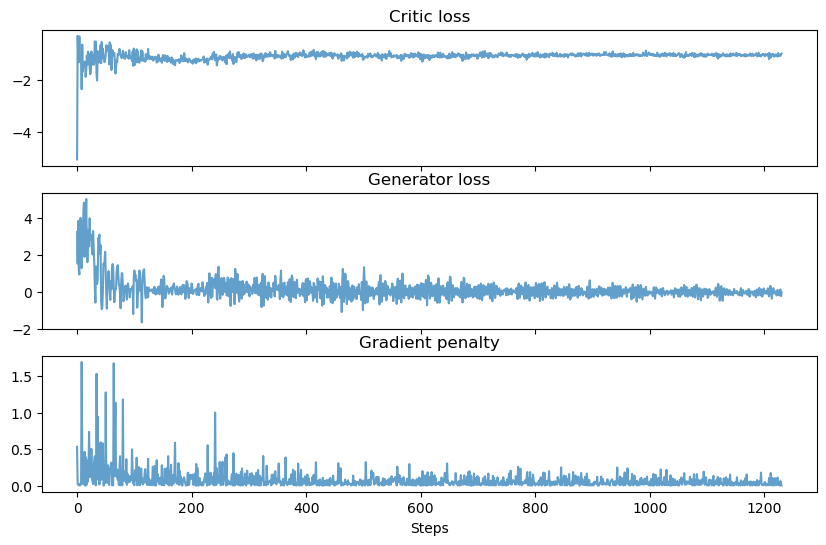

Step 1260: g_loss -0.2038 critic_loss -1.0391 critic fake 0.2007  critic_real -1.2398 penalty 0.0164


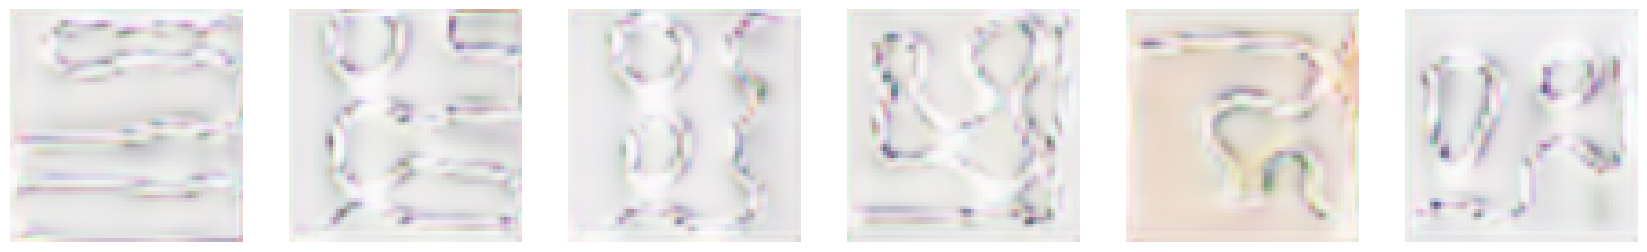

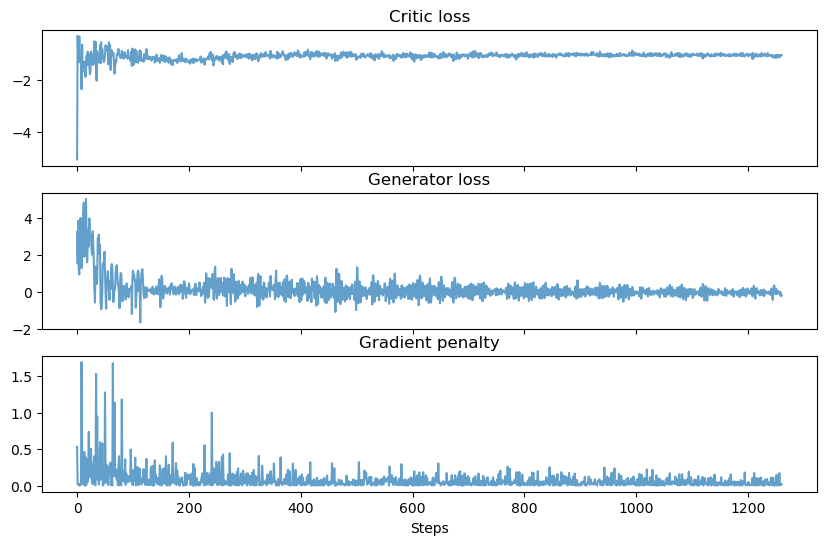

Step 1290: g_loss 0.0346 critic_loss -1.0359 critic fake -0.0516  critic_real -0.9842 penalty 0.0221


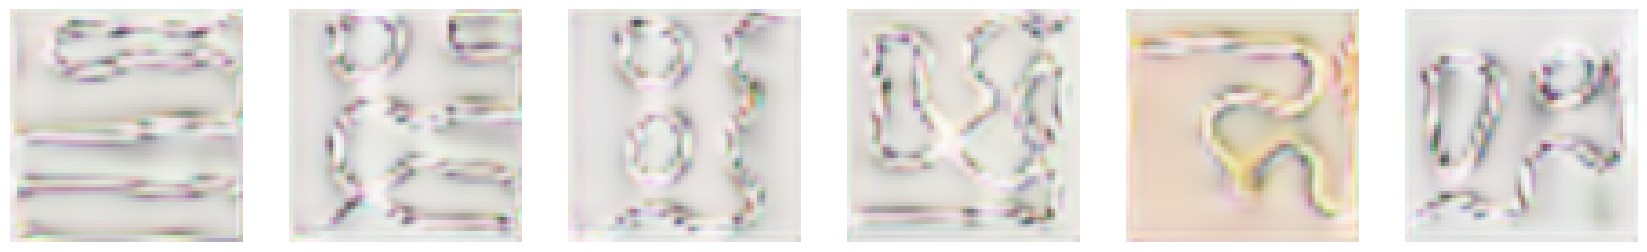

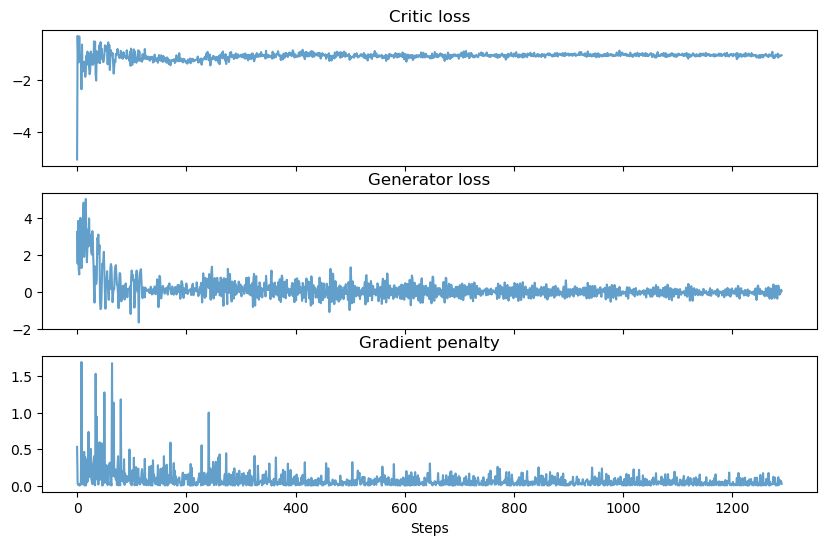

Step 1320: g_loss -0.0790 critic_loss -1.0909 critic fake 0.0326  critic_real -1.1235 penalty 0.0548


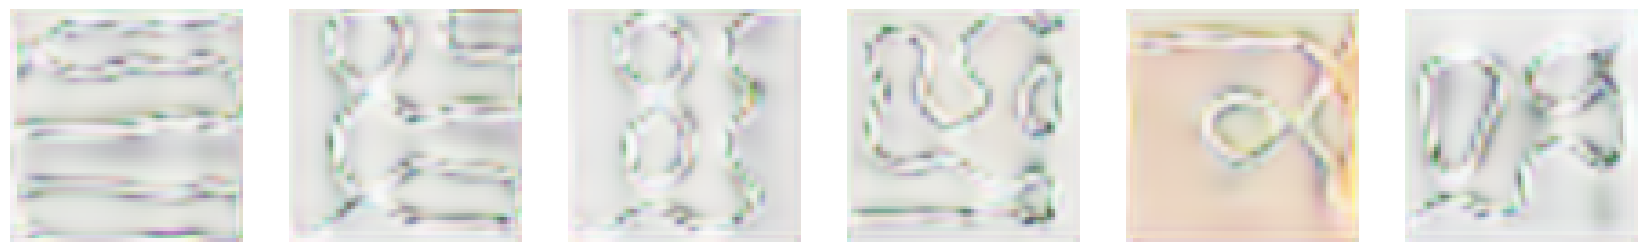

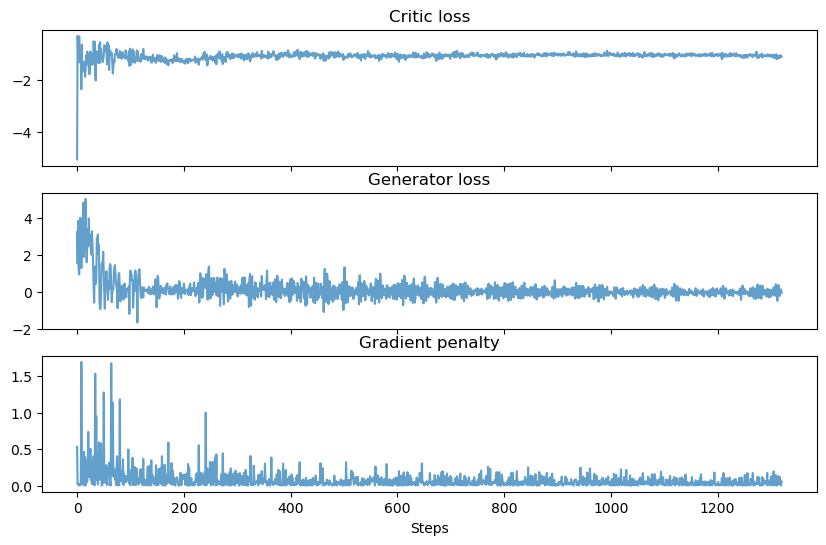

Step 1350: g_loss -0.0731 critic_loss -1.0649 critic fake 0.0918  critic_real -1.1567 penalty 0.0298


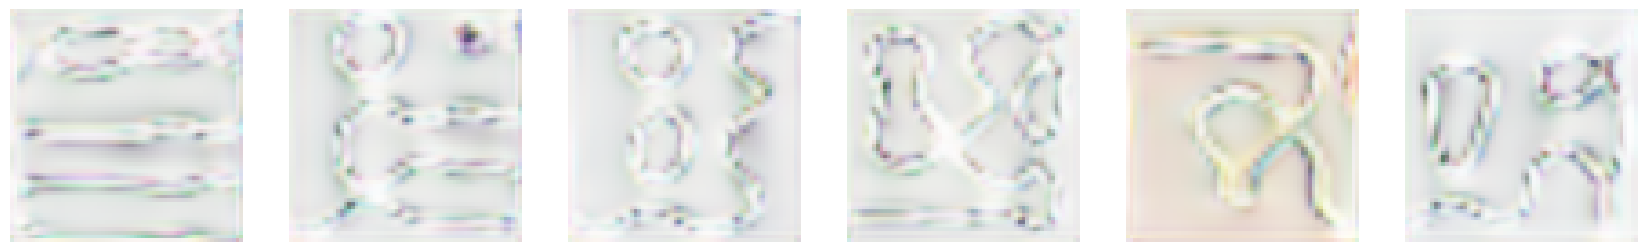

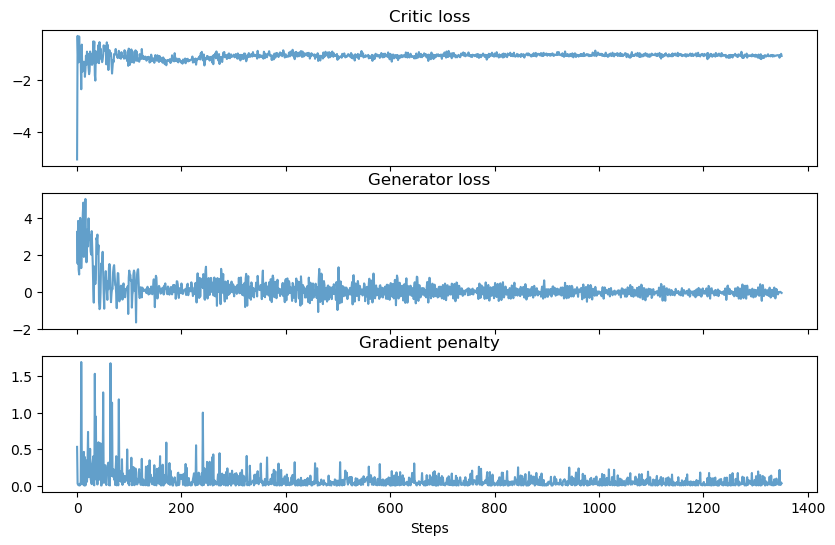

Step 1380: g_loss 0.1139 critic_loss -1.1286 critic fake 0.0936  critic_real -1.2222 penalty 0.2250


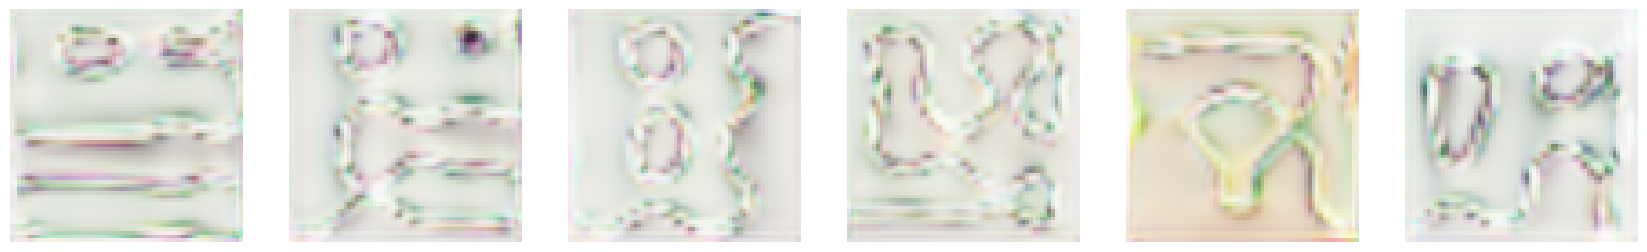

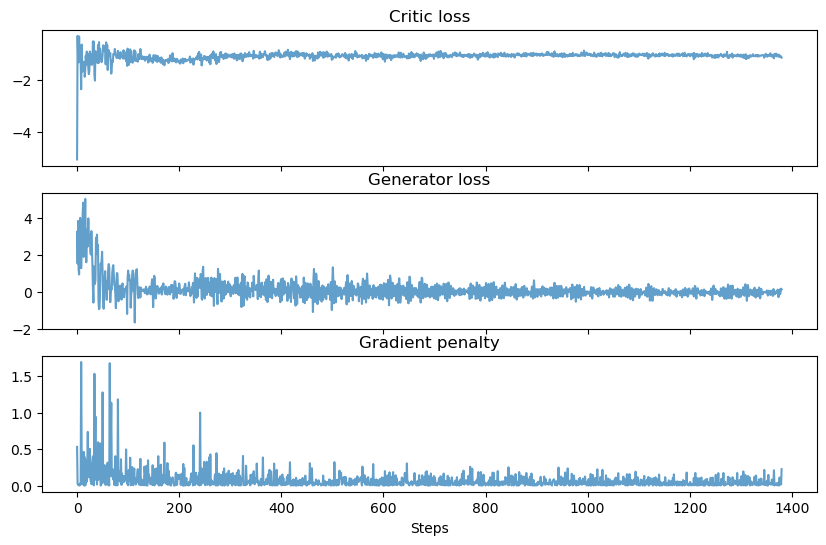

Step 1410: g_loss 0.2070 critic_loss -1.1240 critic fake 0.0584  critic_real -1.1825 penalty 0.1771


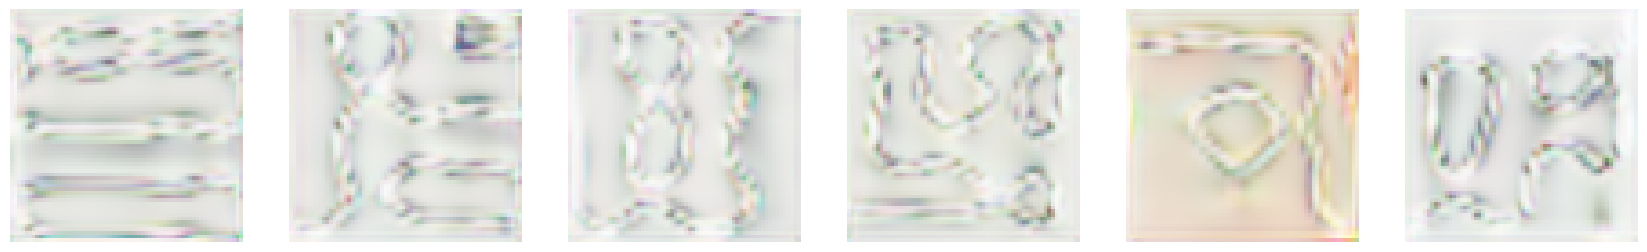

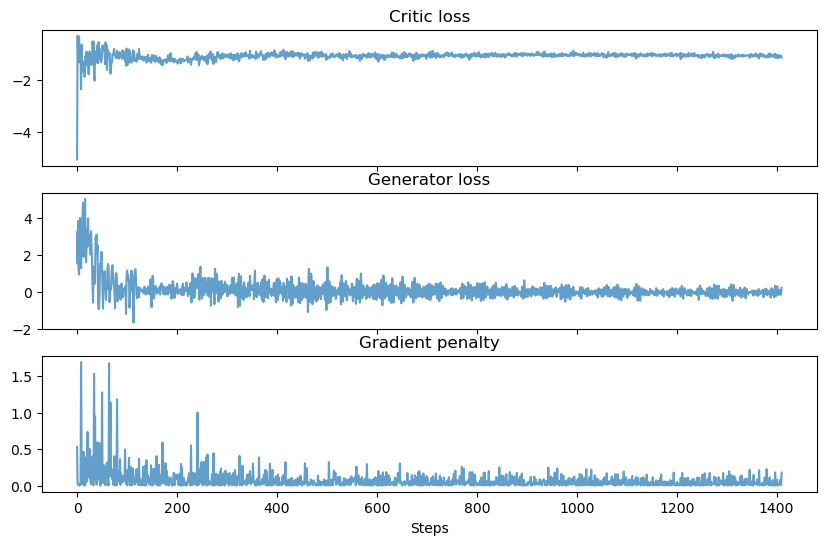

Step 1440: g_loss -0.2767 critic_loss -1.1371 critic fake 0.2100  critic_real -1.3470 penalty 0.0197


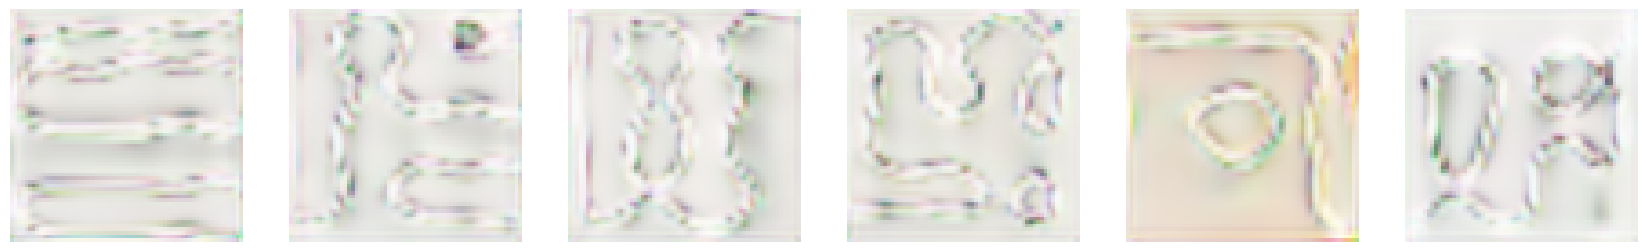

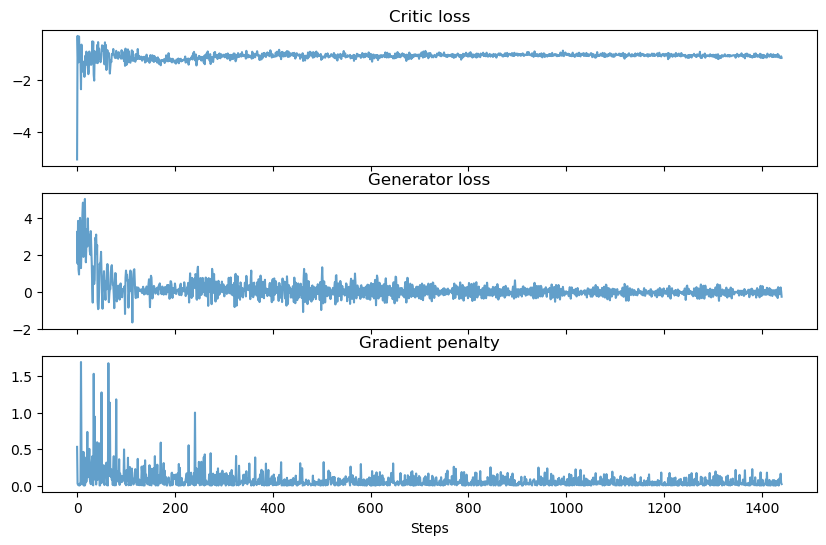

Step 1470: g_loss -0.2902 critic_loss -1.0758 critic fake 0.2939  critic_real -1.3697 penalty 0.0219


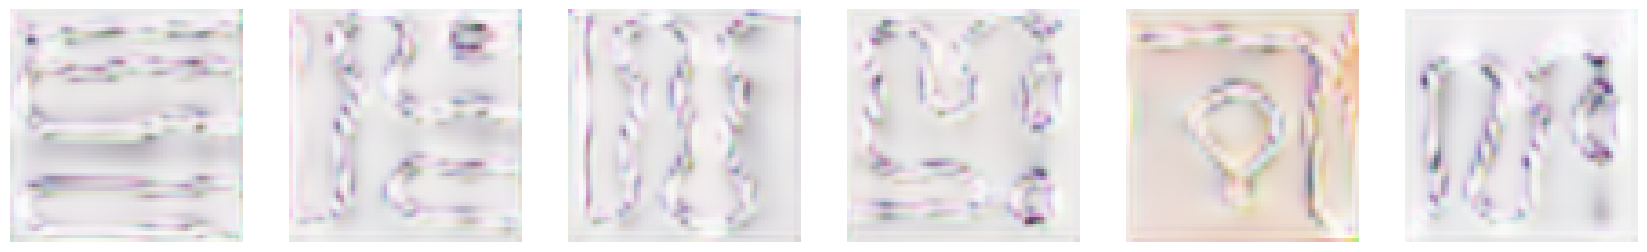

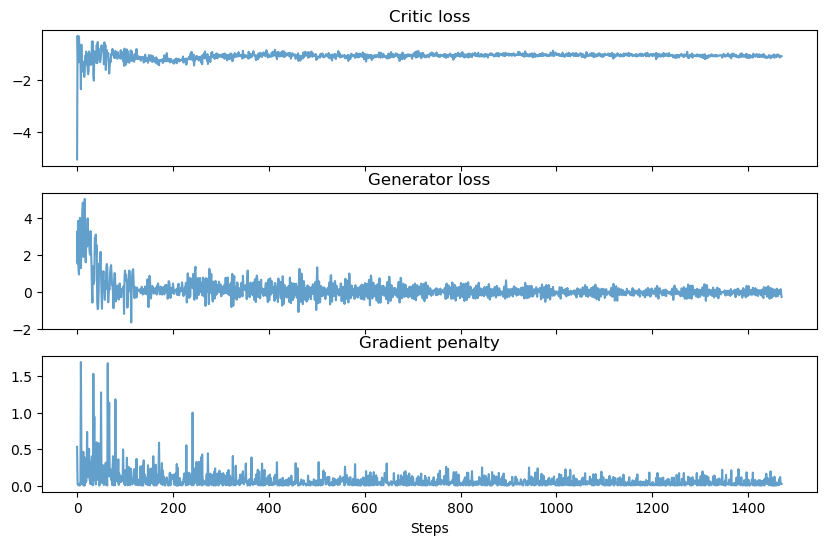

Step 1500: g_loss -0.1678 critic_loss -1.0645 critic fake 0.0933  critic_real -1.1578 penalty 0.0169


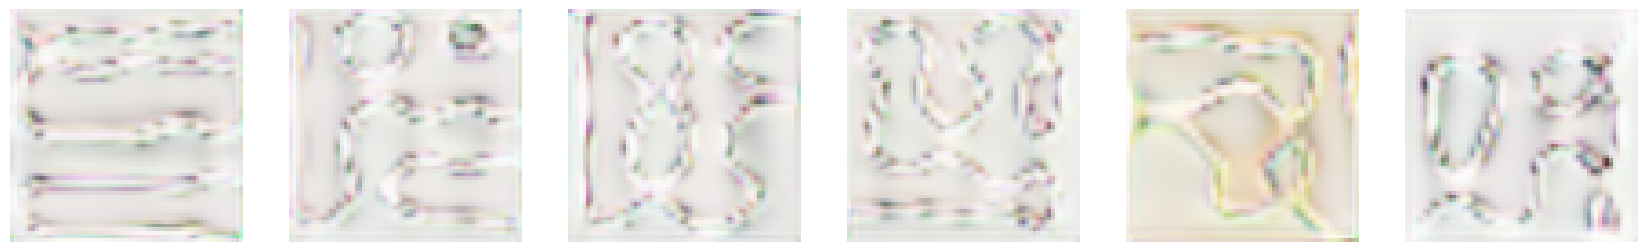

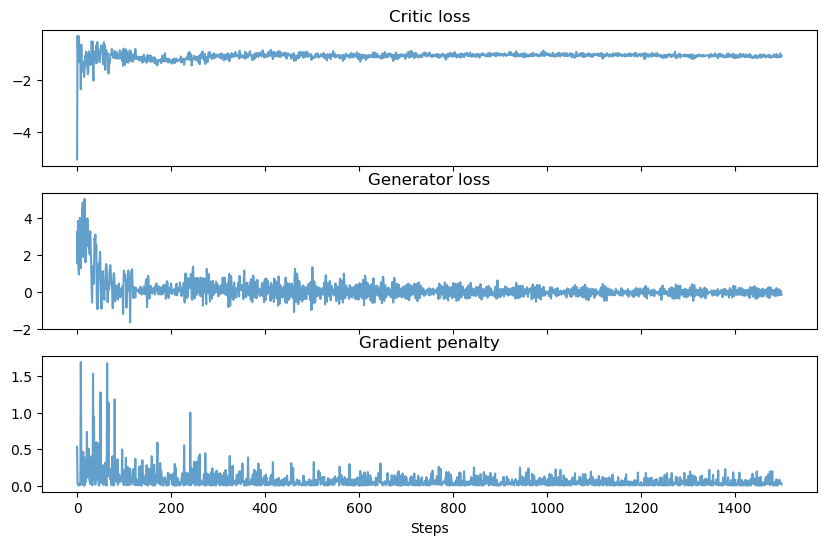

In [ ]:
wgan.train(image_batch, 512, 50000, 30)

In [ ]:
wgan.model.summary()

In [ ]:
wgan.generator.summary()

In [ ]:
wgan.critic.summary()

In [ ]:
z = tf.random.normal((8, 128))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)

In [ ]:
for i in range(20):
    z = tf.random.normal((20, 128))
    images = wgan.generator.predict(z, verbose=0)
    
    grid_row = 1
    grid_col = 20
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*4, grid_row*4))
    for row in range(grid_row):
        for col in range(grid_col):
            axarr[col].imshow(images[col]*0.5+0.5)
            axarr[col].axis('off')
    plt.show()

In [ ]:
wgan.generator.save_weights('wgan_gp_celeb_a.weights')

In [ ]:
wgan.train(iter(ds_train), batch_size, 50000, 30)